<p style="font-family: Arial; font-size:1.6em;color:darkblue;"> Time Series Forecasting: energy production in the United Kingdom </p>

<p style="font-family: Arial; font-size:1.2em;color:darkred;"> Is AR(I)MA an appropriate approach to the problem at hand ? </p>

<p style="font-family: Arial; font-size:1.1em;color:darkblue;"> Dans ce notebook, nous appliquons le modèle ARIMA à la prédiction de la série temporelle représentant la production totale (sum des sources différentes) d'énergie en Grande-Bretagne. La granularité temporelle dans cet étude est mensuelle.</p> 

Le modèle ARIMA suppose: 
* Un processus AR, i.e., autorégressif : si le processus est stationnaire il est consideré comme autorégressif d’ordre **p** si l’on peut expliquer sa valeur à l’instant t en utilisant ses **p** instants précédents.
* Un processus est un processus MA d’ordre q si on peut exprimer sa valeur à l’instant t comme une combinaison linéaire d’erreurs aléatoires (bruit blanc).
* Une combinaison d’un processus AR et d’un processus MA donne ARMA utilisée dans la modélisation des séries temporelles complexes mais obligatoirement stationnaires (sans tendance croissante ou decroissante). Pour pouvoir traiter aussi les séries non-tationnaires le modèle ARIMA (I pour integrated) a été développé. ARIMA opère en différenciant les séries temporelles afin de retirer les tendances qu’elles présentent pour les stationnariser. ARIMA combine ce processus de différenciation avec le processus ARMA. L'ordre de différenciation d est un hyper-paramètre du modèle en ensemble avec les paramètres p et q. Ce paramètre d permet de gérer la différenciation sur les séries non-stationnaires. Nous allons procéder par grid search afin de trouver des valeurs optimales pour p et q. La valeur de d sera déduite de manière empirique.   

In [1]:
# Importing libraries
import pandas as pd
from tqdm import tqdm
from math import sqrt
import datetime  
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import matplotlib as mpl
import numpy as np
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss

# We will use deprecated models of statmodels which throw a lot of warnings 
# to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'

<p style="font-family: Arial; font-size:1.6em;color:darkblue;"> Defining Functions </p>

In [2]:
# Defining useful functions
def test_stationarity(ts):
    
    #Determing rolling statistics
    rolmean = ts.rolling(12).mean()
    rolstd = ts.rolling(12).std()
    
    #Plot rolling statistics:
    plt.figure(figsize=(25,15))
    plt.plot(ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    stats = ['Test Statistic','p-value','Lags','Observations']
    df_test = adfuller(ts, autolag='AIC')
    df_results = pd.Series(df_test[0:4], index=stats)
    for key,value in df_test[4].items():
        df_results['Critical Value (%s)'%key] = value
    return df_results

from sklearn.metrics import r2_score

EPSILON = 1e-10


def _error(actual: np.ndarray, predicted: np.ndarray):
    """Simple error"""
    return actual - predicted

def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error
    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)

def _naive_forecasting(actual: np.ndarray, seasonality: int = 1):
    """Naive forecasting method which just repeats previous samples"""
    return actual[:-seasonality]

def _relative_error(
    actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None
):
    """Relative Error"""
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark
        return _error(actual[seasonality:], predicted[seasonality:]) / (
            _error(actual[seasonality:], _naive_forecasting(actual, seasonality))
            + EPSILON
        )

    return _error(actual, predicted) / (_error(actual, benchmark) + EPSILON)

def _bounded_relative_error(
    actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None
):
    """Bounded Relative Error"""
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark

        abs_err = np.abs(_error(actual[seasonality:], predicted[seasonality:]))
        abs_err_bench = np.abs(
            _error(actual[seasonality:], _naive_forecasting(actual, seasonality))
        )
    else:
        abs_err = np.abs(_error(actual, predicted))
        abs_err_bench = np.abs(_error(actual, benchmark))

    return abs_err / (abs_err + abs_err_bench + EPSILON)


def _geometric_mean(a, axis=0, dtype=None):
    """Geometric mean"""
    if not isinstance(a, np.ndarray):  # if not an ndarray object attempt to convert it
        log_a = np.log(np.array(a, dtype=dtype))
    elif dtype:  # Must change the default dtype allowing array type
        if isinstance(a, np.ma.MaskedArray):
            log_a = np.log(np.ma.asarray(a, dtype=dtype))
        else:
            log_a = np.log(np.asarray(a, dtype=dtype))
    else:
        log_a = np.log(a)
    return np.exp(log_a.mean(axis=axis))


def mse(actual: np.ndarray, predicted: np.ndarray):
    """Mean Squared Error"""
    return np.mean(np.square(_error(actual, predicted)))


def rmse(actual: np.ndarray, predicted: np.ndarray):
    """Root Mean Squared Error"""
    return np.sqrt(mse(actual, predicted))


def nrmse(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Root Mean Squared Error"""
    return rmse(actual, predicted) / (actual.max() - actual.min())


def me(actual: np.ndarray, predicted: np.ndarray):
    """Mean Error"""
    return np.mean(_error(actual, predicted))


def mae(actual: np.ndarray, predicted: np.ndarray):
    """Mean Absolute Error"""
    return np.mean(np.abs(_error(actual, predicted)))


mad = mae  # Mean Absolute Deviation (it is the same as MAE)


def gmae(actual: np.ndarray, predicted: np.ndarray):
    """Geometric Mean Absolute Error"""
    return _geometric_mean(np.abs(_error(actual, predicted)))


def mdae(actual: np.ndarray, predicted: np.ndarray):
    """Median Absolute Error"""
    return np.median(np.abs(_error(actual, predicted)))


def mpe(actual: np.ndarray, predicted: np.ndarray):
    """Mean Percentage Error"""
    return np.mean(_percentage_error(actual, predicted))


def mape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Absolute Percentage Error
    Properties:
        + Easy to interpret
        + Scale independent
        - Biased, not symmetric
        - Undefined when actual[t] == 0
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.abs(_percentage_error(actual, predicted)))


def mdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(np.abs(_percentage_error(actual, predicted)))


def smape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Mean Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.mean(
        2.0
        * np.abs(actual - predicted)
        / ((np.abs(actual) + np.abs(predicted)) + EPSILON)
    )


def smdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(
        2.0
        * np.abs(actual - predicted)
        / ((np.abs(actual) + np.abs(predicted)) + EPSILON)
    )


def maape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Arctangent Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.arctan(np.abs((actual - predicted) / (actual + EPSILON))))


def mase(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """
    Mean Absolute Scaled Error
    Baseline (benchmark) is computed with naive forecasting (shifted by @seasonality)
    """
    return mae(actual, predicted) / mae(
        actual[seasonality:], _naive_forecasting(actual, seasonality)
    )


def std_ae(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Absolute Error"""
    __mae = mae(actual, predicted)
    return np.sqrt(
        np.sum(np.square(_error(actual, predicted) - __mae)) / (len(actual) - 1)
    )


def std_ape(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Absolute Percentage Error"""
    __mape = mape(actual, predicted)
    return np.sqrt(
        np.sum(np.square(_percentage_error(actual, predicted) - __mape))
        / (len(actual) - 1)
    )


def rmspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Mean Squared Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.mean(np.square(_percentage_error(actual, predicted))))


def rmdspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Median Squared Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.median(np.square(_percentage_error(actual, predicted))))


def rmsse(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """Root Mean Squared Scaled Error"""
    q = np.abs(_error(actual, predicted)) / mae(
        actual[seasonality:], _naive_forecasting(actual, seasonality)
    )
    return np.sqrt(np.mean(np.square(q)))


def inrse(actual: np.ndarray, predicted: np.ndarray):
    """Integral Normalized Root Squared Error"""
    return np.sqrt(
        np.sum(np.square(_error(actual, predicted)))
        / np.sum(np.square(actual - np.mean(actual)))
    )


def rrse(actual: np.ndarray, predicted: np.ndarray):
    """Root Relative Squared Error"""
    return np.sqrt(
        np.sum(np.square(actual - predicted))
        / np.sum(np.square(actual - np.mean(actual)))
    )


def mre(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Relative Error"""
    return np.mean(_relative_error(actual, predicted, benchmark))


def rae(actual: np.ndarray, predicted: np.ndarray):
    """Relative Absolute Error (aka Approximation Error)"""
    return np.sum(np.abs(actual - predicted)) / (
        np.sum(np.abs(actual - np.mean(actual))) + EPSILON
    )


def mrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Relative Absolute Error"""
    return np.mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mdrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Median Relative Absolute Error"""
    return np.median(np.abs(_relative_error(actual, predicted, benchmark)))


def gmrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Geometric Mean Relative Absolute Error"""
    return _geometric_mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Bounded Relative Absolute Error"""
    return np.mean(_bounded_relative_error(actual, predicted, benchmark))


def umbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Unscaled Mean Bounded Relative Absolute Error"""
    __mbrae = mbrae(actual, predicted, benchmark)
    return __mbrae / (1 - __mbrae)


def mda(actual: np.ndarray, predicted: np.ndarray):
    """Mean Directional Accuracy"""
    return np.mean(
        (
            np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])
        ).astype(int)
    )


def bias(actual: np.ndarray, predicted: np.ndarray):
    """Mean forecast error(or Forecast Bias)"""
    return np.mean(actual - predicted)


METRICS = {
    "mse": mse,
    "rmse": rmse,
    "nrmse": nrmse,
    "me": me,
    "mae": mae,
    "mad": mad,
    "gmae": gmae,
    "mdae": mdae,
    "mpe": mpe,
    "mape": mape,
    "mdape": mdape,
    "smape": smape,
    "smdape": smdape,
    "maape": maape,
    "mase": mase,
    "std_ae": std_ae,
    "std_ape": std_ape,
    "rmspe": rmspe,
    "rmdspe": rmdspe,
    "rmsse": rmsse,
    "inrse": inrse,
    "rrse": rrse,
    "mre": mre,
    "rae": rae,
    "mrae": mrae,
    "mdrae": mdrae,
    "gmrae": gmrae,
    "mbrae": mbrae,
    "umbrae": umbrae,
    "mda": mda,
    "bias": bias,
    "r2": r2_score,
}


def evaluate(
    actual: np.ndarray, predicted: np.ndarray, metrics=("mae", "rmse", "mape", "r2")
):
    results = {}
    for name in metrics:
        try:
            results[name] = METRICS[name](actual, predicted)
        except Exception as err:
            results[name] = np.nan
            print("Unable to compute metric {0}: {1}".format(name, err))
    return results

def evaluate_all(actual: np.ndarray, predicted: np.ndarray):
    return evaluate(actual, predicted, metrics=set(METRICS.keys()))



# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast-actual)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

In [3]:
# Loading and preparing the data set; Granularity of the data: monthly data
energy_per_month = pd.read_csv('energy_sum_month.csv', sep=",", parse_dates=True)
energy_per_month.head(2)

,timestamp,coal,nuclear,wind,hydro,solar,total
0,2012-01-31,1.557582e+08,6.846972e+07,1.539371e+07,6.375348e+06,0.0,2.459970e+08
1,2012-02-29,1.690382e+08,6.966962e+07,1.363287e+07,4.662923e+06,0.0,2.570037e+08


In [4]:
energy_per_month['Datetime']=pd.to_datetime(energy_per_month['timestamp'], format='%Y-%m-%d %H:%M:%S')

In [5]:
energy_per_month['Date'] = energy_per_month['Datetime'].dt.date
energy_per_month['Year'] = energy_per_month['Datetime'].dt.year
energy_per_month['Month'] = energy_per_month['Datetime'].dt.month.astype(int)
energy_per_month['day_of_month'] = energy_per_month['Datetime'].dt.day.astype(int)

# day_of_week=0 corresponds to Monday
energy_per_month['day_of_week'] = energy_per_month['Datetime'].dt.dayofweek.astype(int)
energy_per_month['hour_of_day'] = energy_per_month['Datetime'].dt.hour.astype(int)
energy_per_month['day_of_week_name'] = energy_per_month['Datetime'].dt.day_name()
energy_per_month['month_name'] = energy_per_month['Datetime'].dt.month_name()

In [6]:
energy_per_month.set_index('Datetime', inplace=True)

In [7]:
energy_per_month.head(2)

,timestamp,coal,nuclear,wind,hydro,solar,total,Date,Year,Month,day_of_month,day_of_week,hour_of_day,day_of_week_name,month_name
Datetime,,,,,,,,,,,,,,,
2012-01-31,2012-01-31,1.557582e+08,6.846972e+07,1.539371e+07,6.375348e+06,0.0,2.459970e+08,2012-01-31,2012,1,31,1,0,Tuesday,January
2012-02-29,2012-02-29,1.690382e+08,6.966962e+07,1.363287e+07,4.662923e+06,0.0,2.570037e+08,2012-02-29,2012,2,29,2,0,Wednesday,February



<p style="font-family: Arial; font-size:1.2em;color:darkred;"> Sources de la production énergétique </p>

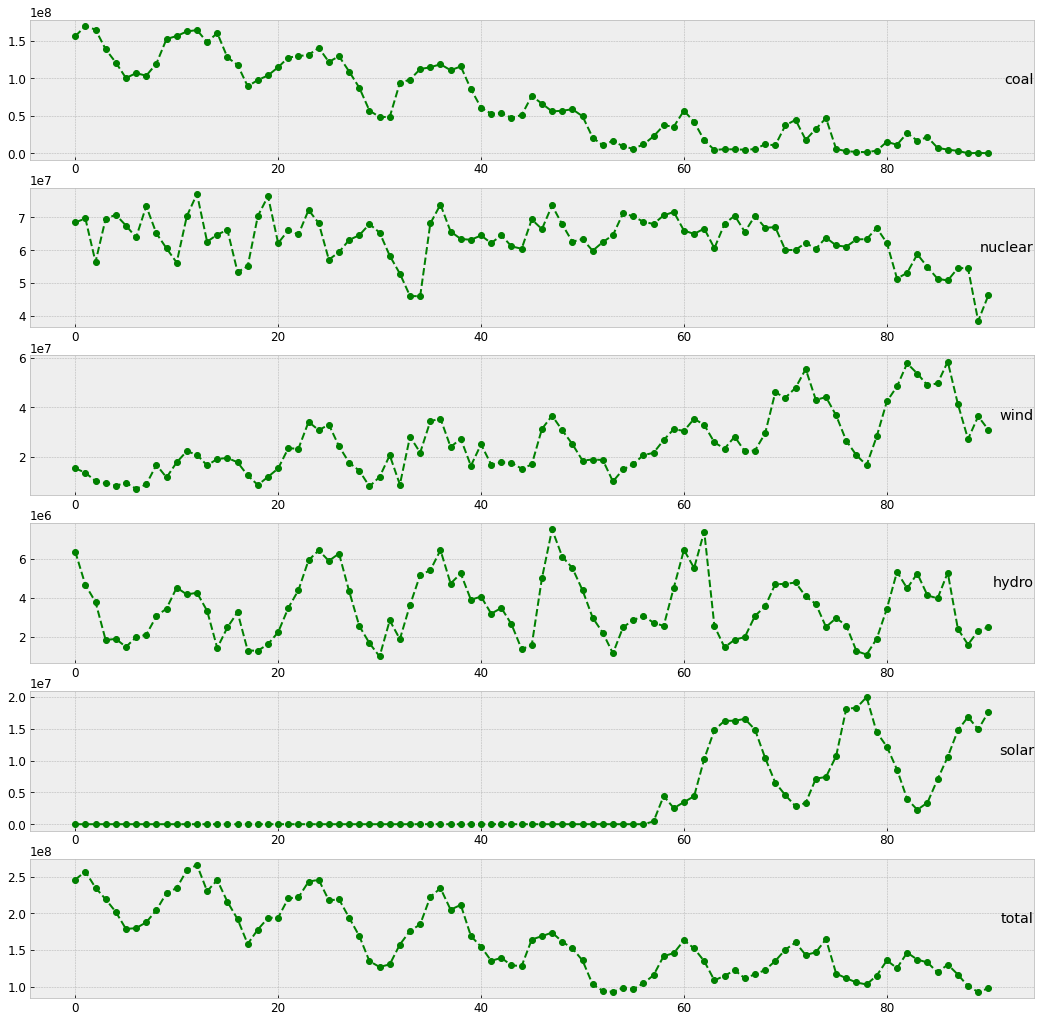

In [8]:
values = energy_per_month.values
sources = [1, 2, 3, 4, 5, 6] 
i = 1
# plot each source
plt.figure(figsize=(18,18))
for source in sources:
    plt.subplot(len(sources), 1, i)
    plt.plot(values[:, source], color='green', marker='o', linestyle='dashed', 
             linewidth=2, markersize=6)
    plt.title(energy_per_month.columns[source], y=0.5, loc='right')
    i += 1
plt.show()

<p style="font-family: Arial; font-size:1.2em;color:darkred;"> Décomposition de la série temporelle en composantes : tendance, saisonnalité, bruit blanc </p>

In [9]:
result = seasonal_decompose(energy_per_month.total, model='multiplicative')

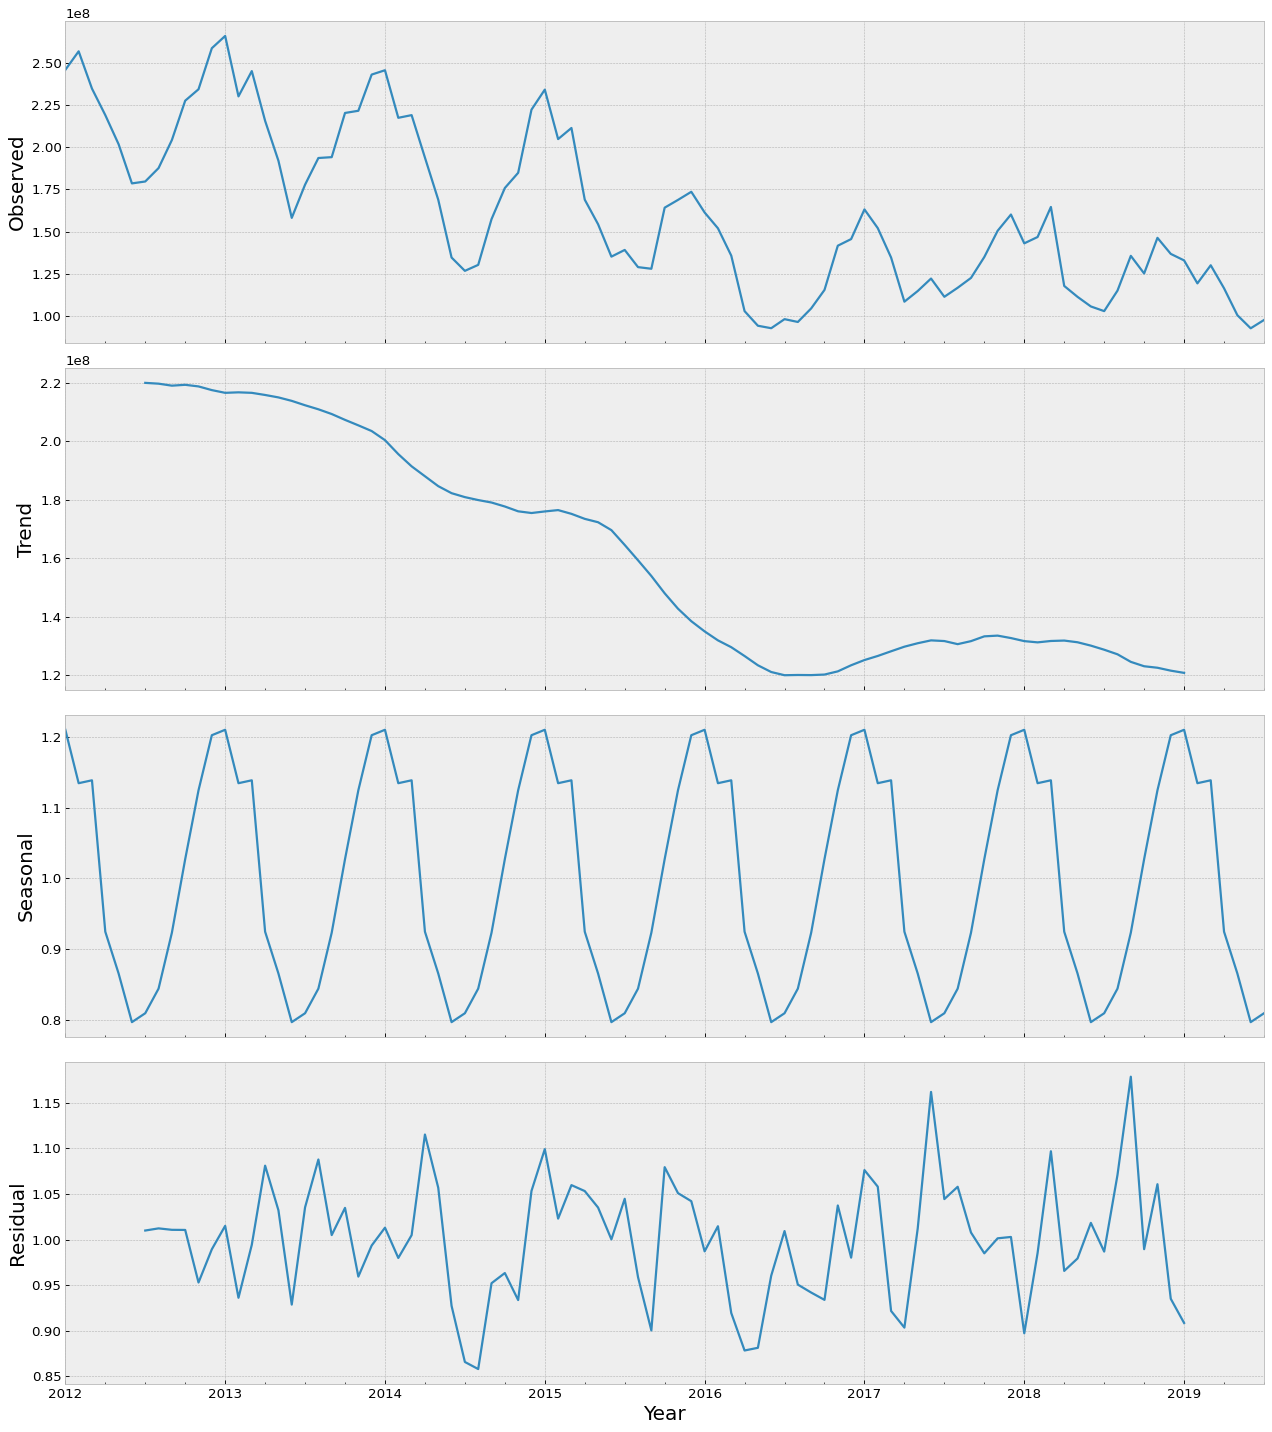

In [10]:
def plotseasonal(res, axes):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed', fontsize=18)
    axes[0].tick_params(axis='both', which='major', labelsize=12)
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend', fontsize=18)
    axes[1].tick_params(axis='both', which='major', labelsize=12)
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal', fontsize=18)
    axes[2].tick_params(axis='both', which='major', labelsize=12)
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual', fontsize=18)
    axes[3].tick_params(axis='both', which='major', labelsize=12)

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(16, 18), dpi=80)

plotseasonal(result, axes[:])
plt.xlabel('Year', fontsize=18)

plt.tight_layout()
plt.show()

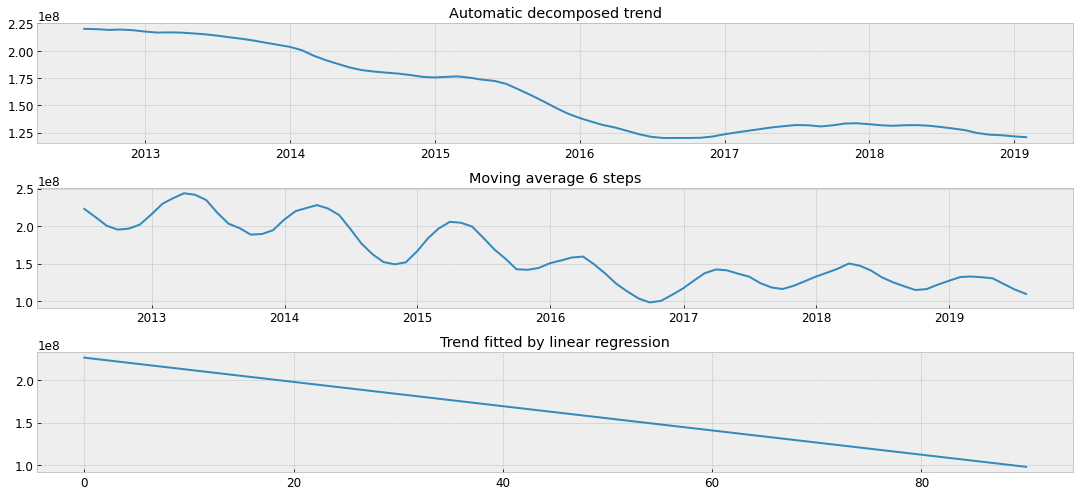

In [11]:
fig = plt.figure(figsize=(15, 7))
layout = (3, 2)
pm_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
mv_ax = plt.subplot2grid(layout, (1, 0), colspan=2)
fit_ax = plt.subplot2grid(layout, (2, 0), colspan=2)

pm_ax.plot(result.trend)
pm_ax.set_title("Automatic decomposed trend")

mm = energy_per_month.total.rolling(6).mean()
mv_ax.plot(mm)
mv_ax.set_title("Moving average 6 steps")


X = [i for i in range(0, len(energy_per_month.total))]
X = np.reshape(X, (len(X), 1))
y = energy_per_month.total.values
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
fit_ax.plot(trend)
fit_ax.set_title("Trend fitted by linear regression")

plt.tight_layout()

<p style="font-family: Arial; font-size:1.0em;color:darkblue;"> La série montre une tendance décroissante et une saisonnalité de 12 mois. Visuellement, elle presente deux branches différentes: avant l'année 2016 et après.   </p>

In [12]:
series = energy_per_month.total

<p style="font-family: Arial; font-size:1.2em;color:darkred;"> Auto-corrélation (ACF) et Auto-corrélation partialle (PACF)</p>

Text(0.5, 0, 'Lags')

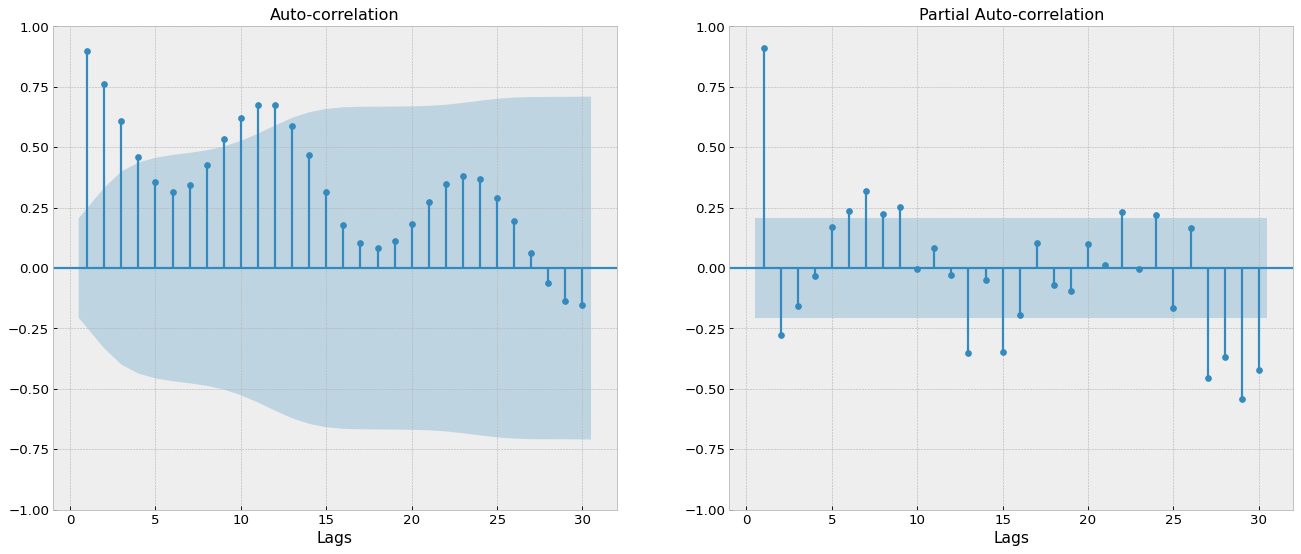

In [13]:
fig = plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
layout = (1, 2)
acf_ax = plt.subplot2grid(layout, (0, 0))
pacf_ax = plt.subplot2grid(layout, (0, 1))

plot_acf(series, lags=30,  zero = False, ax=acf_ax)
acf_ax.set_title("Auto-correlation")
acf_ax.set_xlabel('Lags', fontsize=14)

plot_pacf(series, zero = False, lags=30, ax=pacf_ax)
pacf_ax.set_title("Partial Auto-correlation")
pacf_ax.set_xlabel('Lags', fontsize=14)

<p style="font-family: Arial; font-size:1.0em;color:darkblue;">Les diagrammes d'auto-corrélation et d'auto-corrélation partialle montrent des lags de magnitude importante à longue intervalle t. L'ACF réflecte aussi la saisonnalité de la série.</p>  

<p style="font-family: Arial; font-size:1.2em;color:darkred;"> Vérifier la stationnarité de la série</p>

1) Augmented Dickey–Fuller (ADF) test (voir https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/)

* Hypothèse nulle: La série a une racine unitaire : la série est non-stationnaire.

* Hypothèse 1: La série n'a pas une racine unitaire : la série est probablement stationnaire.

Si l'hypothèse nulle **n'est pas rejetée** (p-value > 0.05), on ne peut pas dire que la série est stationnaire. 

2) Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (tendance linéaire) --> **ce test vérifie si la série est stationnaire dans la présence d'une tendance déterministe**, !stationnarité autour d'une tendance déterministe! (voir https://www.machinelearningplus.com/time-series/kpss-test-for-stationarity/)

* Hypothèse nulle : La série est stationnaire.

* Hypothèse 1 : La série n'est pas stationnaire.

In [14]:
def adftest(ts):
    print ('Augmented Dickey-Fuller Test:')
    dftest = adfuller(ts, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used For ADF Regression and Critical Values Calculation'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

def adf_test(ts):
    dftest = adfuller(ts, autolag = 'AIC')
    print ('Augmented Dickey-Fuller Test:')
    print("1. Test Statistic : ",dftest[0])
    print("2. p-value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)

def kpsstest(ts):
    print ('Kwiatkowski-Phillips-Schmidt-Shin Test:')
    kpsstest = kpss(ts, regression='ct', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [15]:
adftest(energy_per_month.total)

Augmented Dickey-Fuller Test:
Test Statistic                                                                    -0.901970
p-value                                                                            0.787323
#Lags Used                                                                         8.000000
Number of Observations Used For ADF Regression and Critical Values Calculation    82.000000
Critical Value (1%)                                                               -3.512738
Critical Value (5%)                                                               -2.897490
Critical Value (10%)                                                              -2.585949
dtype: float64


Le test ADF montre que la série n'est pas stationnaire (p > 0.05 et Test Statistic value > des valeurs critiques [Critical Value (1, 5, ou 10%)]).  

In [16]:
kpsstest(energy_per_month.total)

Kwiatkowski-Phillips-Schmidt-Shin Test:
Test Statistic           0.109358
p-value                  0.100000
Lags Used                5.000000
Critical Value (10%)     0.119000
Critical Value (5%)      0.146000
Critical Value (2.5%)    0.176000
Critical Value (1%)      0.216000
dtype: float64


Le test KPSS montre que la série est stationnaire autours d'une tendance déterministe (p > 0.05 et Test Statistic value < des valeurs critiques [Critical Value (1, 5, ou 10%)]), voir https://www.machinelearningplus.com/time-series/kpss-test-for-stationarity/) pour plus des précisions.  

Si une série est stationnaire autours d'une tendance déterministe (test KPSS) mais non-stationnaire selon le test ADF, il doit être possible de modeler cette série et produire des forecasts. La série est en tendance stationnaire. La tendance doit être enlevée pour rendre la série strictement stationnaire. La stationnarité de la série sans tendance doit être vérifiée. 

Nous allons procéder d'avantage avec la stationnarisation de la série.   

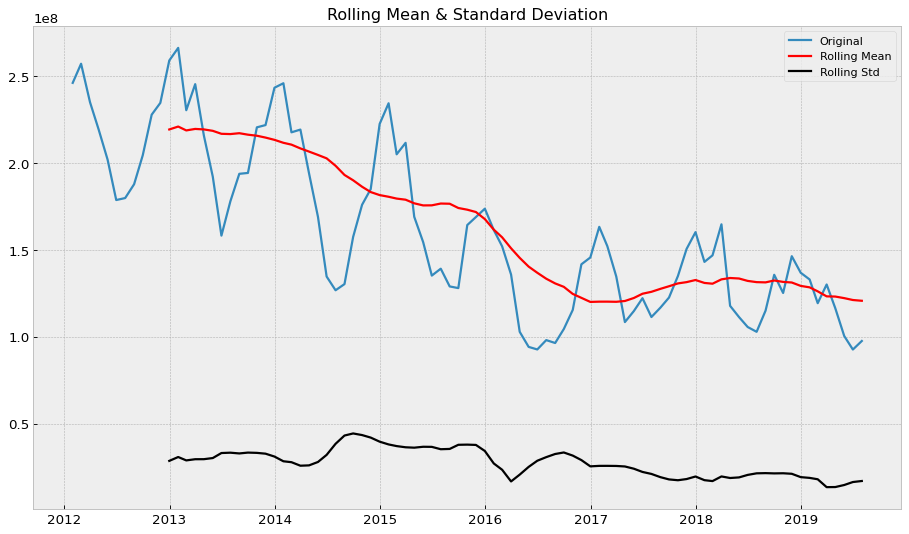

In [17]:
# Determing rolling statistics
fig = plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
rolmean = energy_per_month.total.rolling(window=12).mean()
rolstd = energy_per_month.total.rolling(window=12).std()

# Plot rolling statistics:
orig = plt.plot(energy_per_month.total, label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

La moyenne glissante ainsi que l'écart type glissant ne sont pas constants dans le temps --> indications d'une série non-stationnaire. 

Text(0, 0.5, 'Autocorrelation')

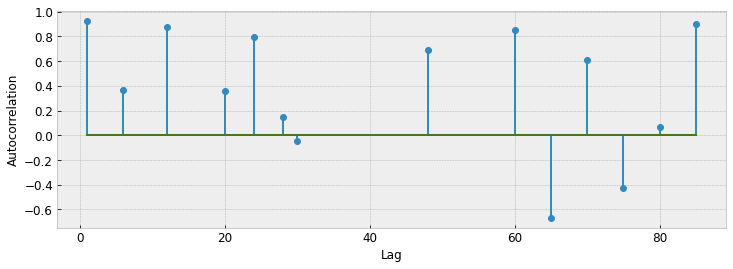

In [18]:
lags = [1, 6, 12, 20, 24, 28, 30, 48, 60, 65, 70, 75, 80, 85] 
autocorrs = [energy_per_month.total.autocorr(lag=lag) 
                   for lag in lags]
plt.figure(figsize=(12, 4))
plt.stem(lags, autocorrs)
plt.xlabel("Lag", fontsize=12)
plt.ylabel("Autocorrelation", fontsize=12)


<p style="font-family: Arial; font-size:1.2em;color:darkred;"> Retirer la saisonnalité de la série </p>

Nous commençons par retirant la saisonnalité de la série afin de pouvoir utiliser ARIMA.

In [19]:
energy_per_month["de-season"] = energy_per_month.total - energy_per_month.total.shift(12)

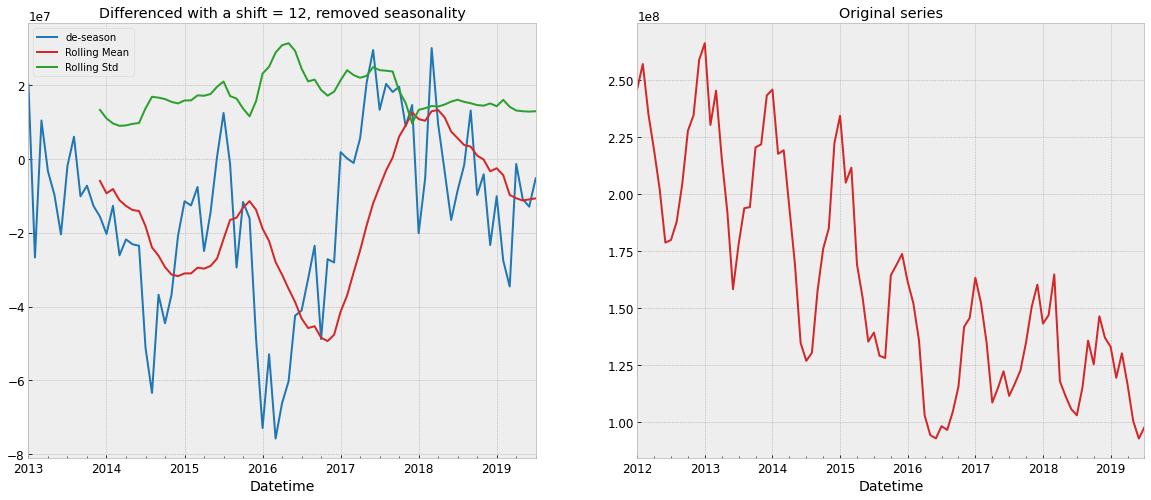

In [20]:
rolmean_diff = energy_per_month["de-season"].dropna().rolling(window=12).mean()
rolstd_diff = energy_per_month["de-season"].dropna().rolling(window=12).std()

ax1 = plt.subplot(121)
energy_per_month["de-season"].dropna().plot(figsize=(20,8),color="tab:blue", title="Differenced with a shift = 12, removed seasonality", ax=ax1);
rolmean_diff.plot(figsize=(20,8),color="tab:red", label='Rolling Mean', ax=ax1);
rolstd_diff.plot(figsize=(20,8),color="tab:green", label='Rolling Std', ax=ax1);
ax1.legend()
ax2 = plt.subplot(122)
energy_per_month["total"].plot(figsize=(20,8), color="tab:red", title="Original series", ax=ax2);


In [21]:
adftest(energy_per_month["de-season"].dropna())

Augmented Dickey-Fuller Test:
Test Statistic                                                                    -1.650389
p-value                                                                            0.456838
#Lags Used                                                                        12.000000
Number of Observations Used For ADF Regression and Critical Values Calculation    66.000000
Critical Value (1%)                                                               -3.533560
Critical Value (5%)                                                               -2.906444
Critical Value (10%)                                                              -2.590724
dtype: float64


In [22]:
kpsstest(energy_per_month["de-season"].dropna()) 

Kwiatkowski-Phillips-Schmidt-Shin Test:
Test Statistic           0.125413
p-value                  0.088124
Lags Used                5.000000
Critical Value (10%)     0.119000
Critical Value (5%)      0.146000
Critical Value (2.5%)    0.176000
Critical Value (1%)      0.216000
dtype: float64


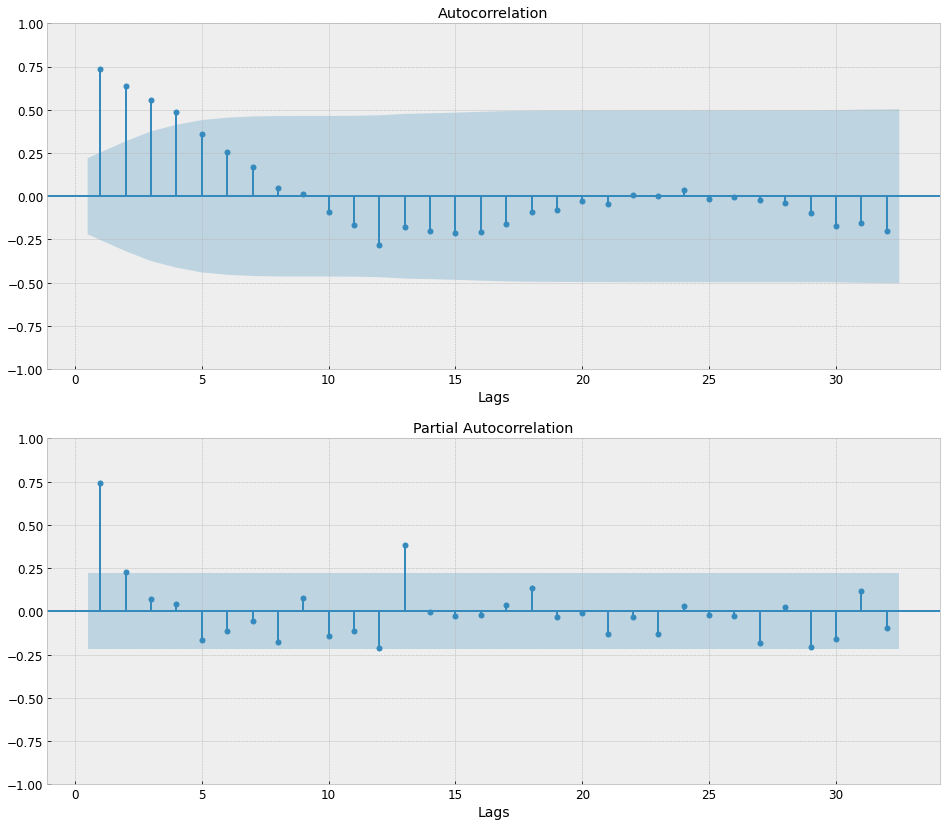

In [23]:
# ACF, PACF graphs to help us determine empirically the p and q parameters of the ARIMA model
fig = plt.figure(figsize=(16,14))
ax1 = fig.add_subplot(211)
ax1.set_xlabel('Lags', fontsize=14)
fig = plot_acf(energy_per_month["de-season"].dropna(inplace=False)[0:].values, zero = False, lags=32, ax=ax1)   # first value of diff is NaN
ax2 = fig.add_subplot(212)
ax2.set_xlabel('Lags', fontsize=14)
fig = plot_pacf(energy_per_month["de-season"].dropna(inplace=False)[0:].values, zero = False,  lags=32, ax=ax2)  # first value of diff is NaN

La série désaisonnalisée n'est pas stationnaire selon le test ADF et elle est encore en tendance stationnaire selon le test KPSS. Nous allons la 
différencier en appliquant un lag = 1 et soustrayant la série désaisonnalisée d'elle même.

In [24]:
energy_per_month["difference"] = energy_per_month["de-season"] - energy_per_month["de-season"].shift(1)

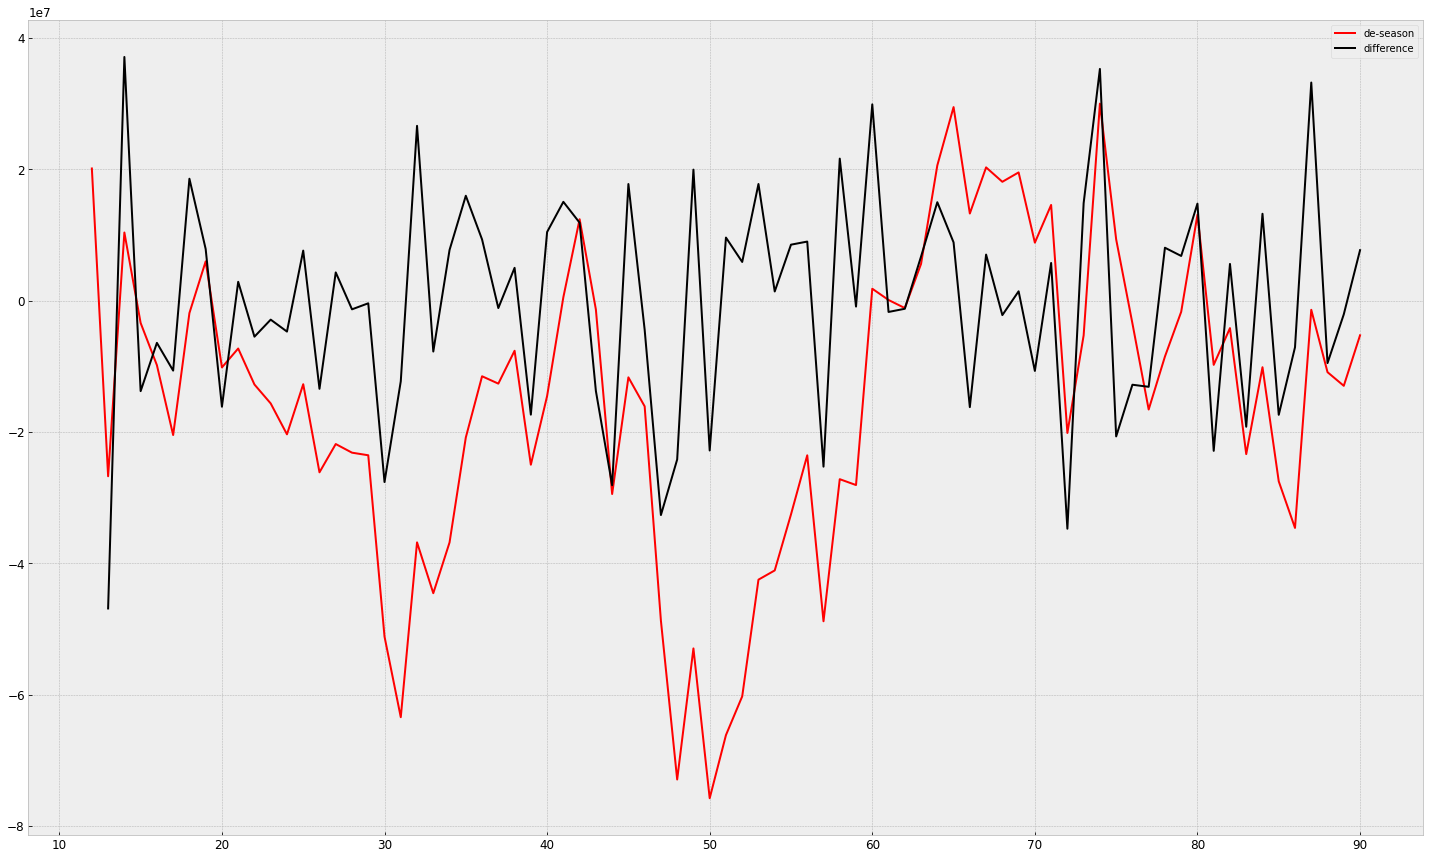

In [25]:
plt.figure(figsize=(25,15))
plt.plot(energy_per_month["de-season"].values, color='red',label='de-season')
plt.plot(energy_per_month["difference"].values, color='black',label= 'difference')
plt.legend(loc='best')
plt.show(block=False)

In [26]:
adftest(energy_per_month["difference"].dropna())

Augmented Dickey-Fuller Test:
Test Statistic                                                                    -3.673779
p-value                                                                            0.004497
#Lags Used                                                                        11.000000
Number of Observations Used For ADF Regression and Critical Values Calculation    66.000000
Critical Value (1%)                                                               -3.533560
Critical Value (5%)                                                               -2.906444
Critical Value (10%)                                                              -2.590724
dtype: float64


In [27]:
kpsstest(energy_per_month["difference"].dropna()) 

Kwiatkowski-Phillips-Schmidt-Shin Test:
Test Statistic           0.067596
p-value                  0.100000
Lags Used                9.000000
Critical Value (10%)     0.119000
Critical Value (5%)      0.146000
Critical Value (2.5%)    0.176000
Critical Value (1%)      0.216000
dtype: float64


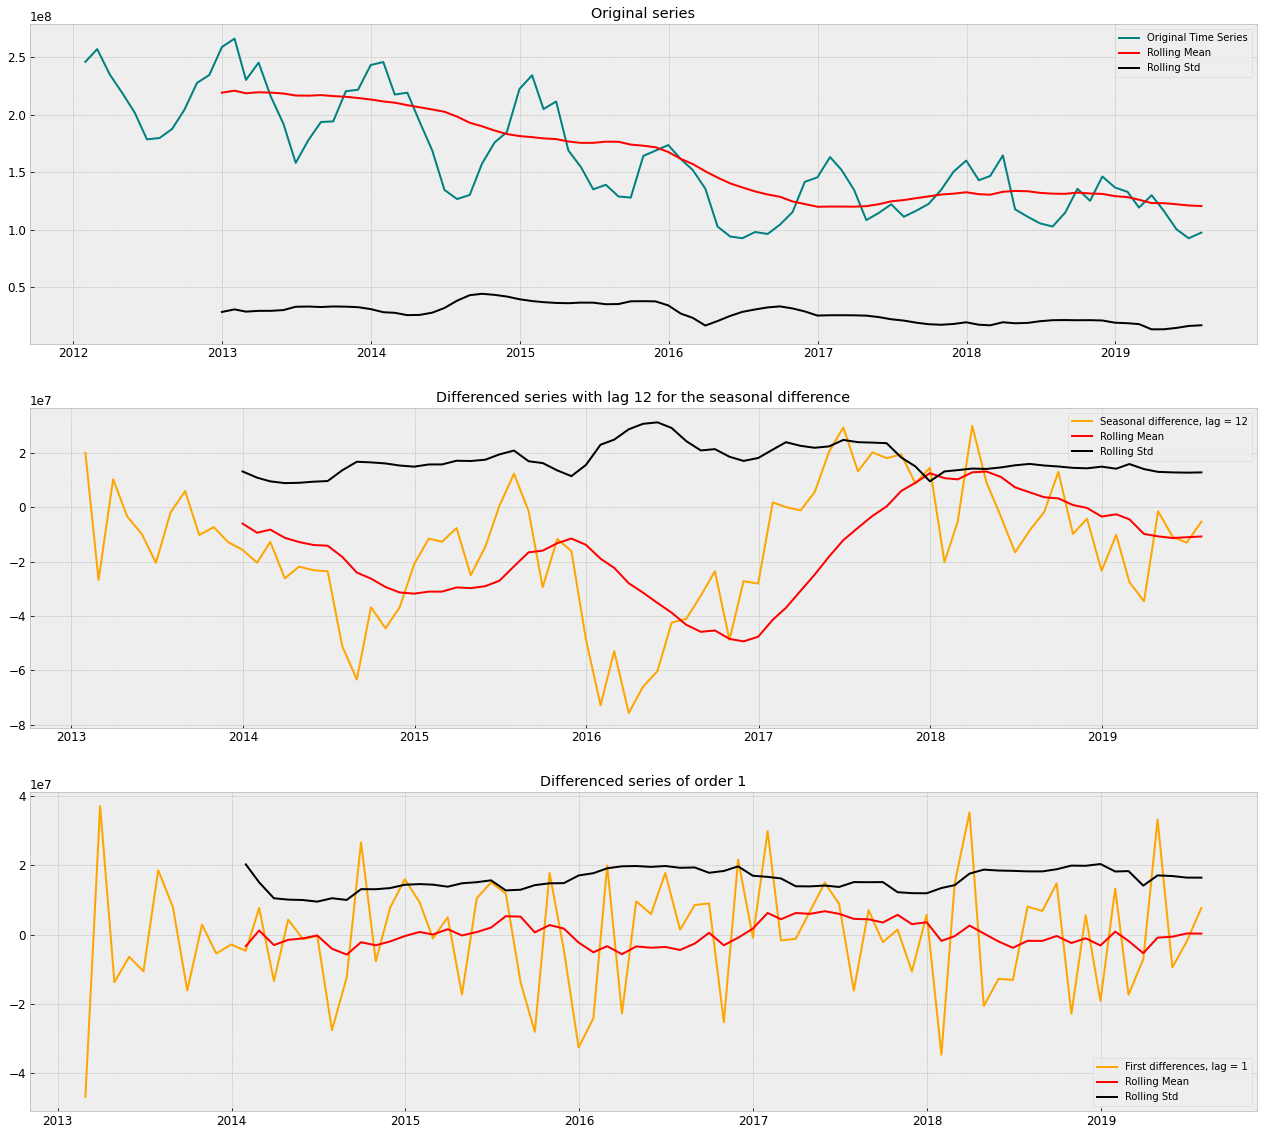

In [28]:
fig = plt.figure(figsize=(22, 20))
layout = (3, 1)
original = plt.subplot2grid(layout, (0, 0), colspan=2)
lag12 = plt.subplot2grid(layout, (1, 0))
lag12order1 = plt.subplot2grid(layout, (2, 0), colspan=2)

original.set_title('Original series')
original.plot(energy_per_month.total, color='teal', label="Original Time Series")
original.plot(energy_per_month.total.rolling(
    12).mean(), color='red', label='Rolling Mean')
original.plot(energy_per_month.total.rolling(12).std(),
              color='black', label='Rolling Std')
original.legend(loc='best')

lag12.set_title('Differenced series with lag 12 for the seasonal difference')
lag12.plot(energy_per_month['de-season'].dropna(inplace=False), color='orange', label="Seasonal difference, lag = 12")
lag12.plot(energy_per_month['de-season'].dropna(inplace=False).rolling(12).mean(), color='red', label='Rolling Mean')
lag12.plot(energy_per_month['de-season'].dropna(inplace=False).rolling(12).std(), color='black', label='Rolling Std')
lag12.legend(loc='best')

lag12order1.set_title('Differenced series of order 1')
lag12order1.plot(energy_per_month['difference'].dropna(inplace=False), color='orange', label="First differences, lag = 1")
lag12order1.plot(energy_per_month['difference'].dropna(inplace=False).rolling(12).mean(),
                color='red', label='Rolling Mean')
lag12order1.plot(energy_per_month['difference'].dropna(inplace=False).rolling(12).std(),
                color='black', label='Rolling Std')
lag12order1.legend(loc='best')

La série désaisonnalisée et différenciée est stationnaire selon le test ADF. KPSS indique une non-stationnarité et ADF indique une stationnarité --> la série est stationnaire par différence. Normalement, la différenciation doit être utilisée pour rendre la série strictement stationnaire. Nous n'allons pas cependant éffectuer une deuxième différenciation en vue de faible non-stationnarité de la série et les résultats ACF et PACF (voir la figure suivante). Nous voulons aussi éviter la sur-différenciation de la série. 

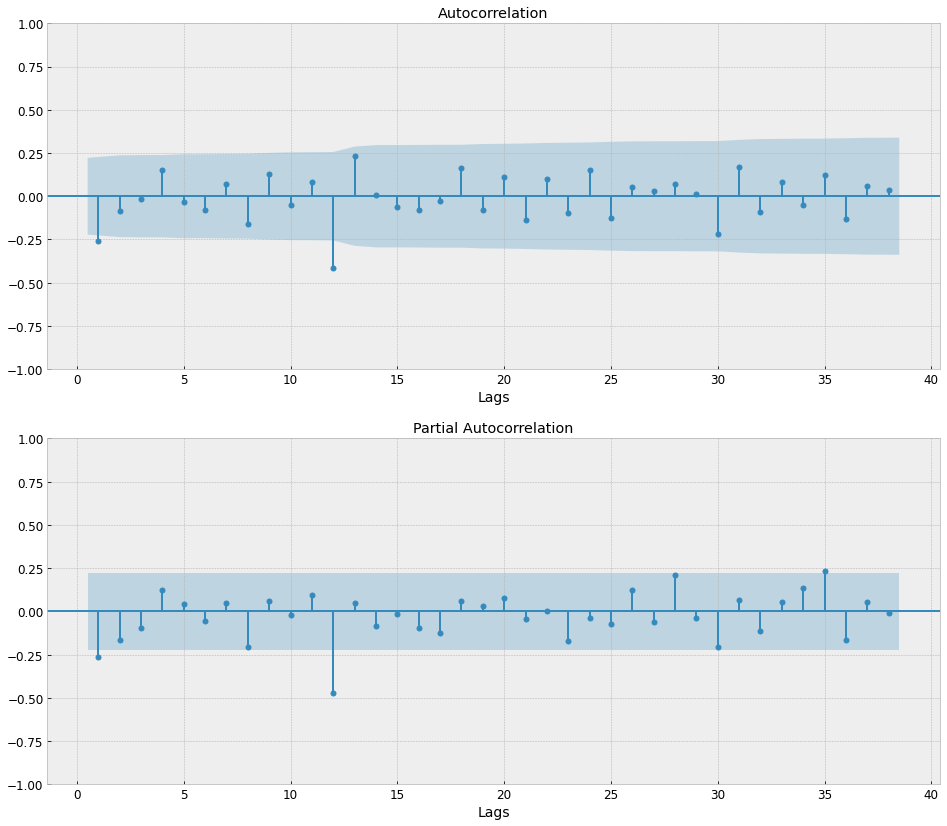

In [29]:
# ACF, PACF graphs to help us determine empirically the p and q parameters of the AR(I)MA model
fig = plt.figure(figsize=(16,14))
ax1 = fig.add_subplot(211)
ax1.set_xlabel('Lags', fontsize=14)
fig = plot_acf(energy_per_month["difference"].dropna(inplace=False)[0:].values, zero = False, lags=38, ax=ax1)   # first value of diff is NaN
ax2 = fig.add_subplot(212)
ax2.set_xlabel('Lags', fontsize=14)
fig = plot_pacf(energy_per_month["difference"].dropna(inplace=False)[0:].values, zero = False,  lags=38, ax=ax2)  # first value of diff is NaN

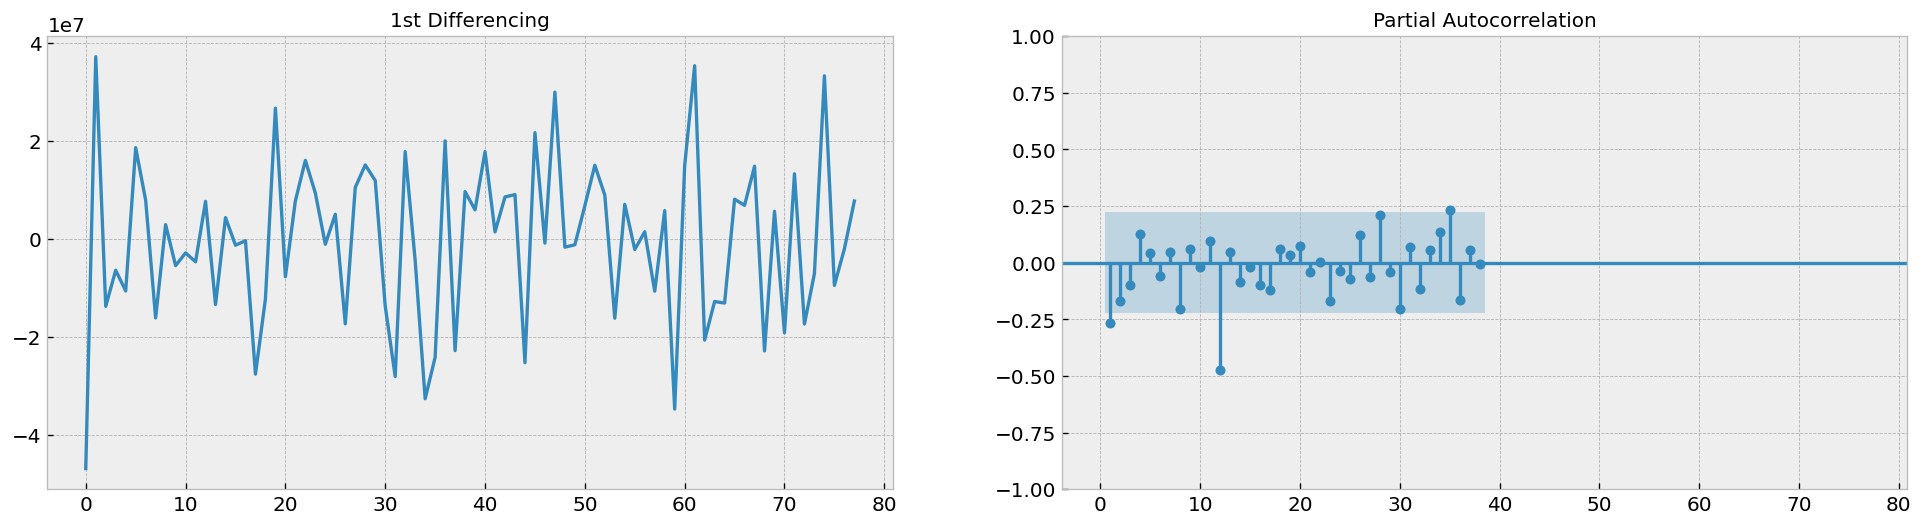

In [30]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(20,5), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(energy_per_month["difference"].dropna(inplace=False).values); 
axes[0].set_title('1st Differencing', fontsize=12)
axes[1].set(ylim=(0,5))
plot_pacf(energy_per_month["difference"].dropna(inplace=False)[0:].values, zero = False, lags=38, ax=axes[1])   # first value of diff is NaN
axes[1].set_title('Partial Autocorrelation', fontsize=12)
plt.show()

### <p style="font-family: Arial; font-size:1.2em;color:darkred;"> Préparer les données </p>

In [31]:
# We split our dataset into train and test
arima_data = energy_per_month['difference'].dropna(inplace=False)
resultsDict = {}
predictionsDict = {}

split_date = '2018-12-31'
df_training = arima_data.loc[arima_data.index <= split_date]
df_test = arima_data.loc[arima_data.index > split_date]
print(f"{len(df_training)} months of training data \n {len(df_test)} months of testing data ")

71 months of training data 
 7 months of testing data 


À l'aide des ACF et PACF nous avons identifié les paramètres p et q de manière empirique. Dans notre cas ces paramètres sont p = 2 et q = 2. Cette approche empirique est qu'une première estimation. 
Il est généralement préférable d'utiliser un grid search pour tester les différentes combinaisons des paramètres. Des critères sont exploités afin de retenir le meilleur modèle : critère d'information d'Akaike (AIC) et critère d'information bayésien (BIC). Le critérion AIC est le plus souvent utilisé. Le BIC est privilégié pour les modèles plus simples même s'il est légèrement moins performant.

 ### <p style="font-family: Arial; font-size:1.2em;color:darkred;"> Grid Search </p>
 
 
Nous allons effectuer le Grid Search en utilisant la série désaisonnalisée et différenciée. La valeur du paramètre est donc fixée égale à 0 (d=0, aucune différenciation est nécessaire, la série est stationnaire).  

In [32]:
X = energy_per_month['difference'].dropna(inplace=False)

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    size = int(len(df_training))
    train, test = X[0:size], X[size:size+int(len(df_test))]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out the mse or rmse
    # error = mean_squared_error(test, predictions)
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse,  model_fit.aic,  model_fit.bic

In [33]:
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    
    # dataframe de retours
    arima_grid = pd.DataFrame(columns=['pdq','rmse','AIC','BIC'])
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse, aic, bic = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                    arima_grid = arima_grid.append(pd.DataFrame([[order, rmse, aic, bic]], columns=arima_grid.columns))
                except:
                    continue
                    print('Exception')
                    
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    return arima_grid

In [34]:
p_values = range(2, 10)
d_values = range(1)
q_values = range(2, 9)

In [37]:
arima_grid = evaluate_models(X, p_values, d_values, q_values)

ARIMA(2, 0, 2) RMSE=15876765.773
ARIMA(2, 0, 3) RMSE=13482903.610
ARIMA(2, 0, 4) RMSE=16399400.075
ARIMA(2, 0, 5) RMSE=15472870.775
ARIMA(2, 0, 6) RMSE=15188924.453
ARIMA(2, 0, 7) RMSE=15549318.254
ARIMA(2, 0, 8) RMSE=16456157.132
ARIMA(3, 0, 2) RMSE=15053144.289
ARIMA(3, 0, 3) RMSE=14577459.060
ARIMA(3, 0, 4) RMSE=13382155.446
ARIMA(3, 0, 5) RMSE=19606265.453
ARIMA(3, 0, 6) RMSE=16054843.215
ARIMA(3, 0, 7) RMSE=15117516.374
ARIMA(3, 0, 8) RMSE=15250951.297
ARIMA(4, 0, 2) RMSE=15726837.457
ARIMA(4, 0, 3) RMSE=15095762.723
ARIMA(4, 0, 4) RMSE=15952254.558
ARIMA(4, 0, 5) RMSE=18761915.603
ARIMA(4, 0, 6) RMSE=19685276.413
ARIMA(4, 0, 7) RMSE=16533078.913
ARIMA(4, 0, 8) RMSE=14555607.108
ARIMA(5, 0, 2) RMSE=16429554.038
ARIMA(5, 0, 3) RMSE=14408148.704
ARIMA(5, 0, 4) RMSE=13439596.681
ARIMA(5, 0, 5) RMSE=20240129.062
ARIMA(5, 0, 6) RMSE=18113800.976
ARIMA(5, 0, 7) RMSE=16975998.266
ARIMA(5, 0, 8) RMSE=16379113.074
ARIMA(6, 0, 2) RMSE=16155181.157
ARIMA(6, 0, 3) RMSE=15728665.738
ARIMA(6, 0

In [38]:
arima_grid.sort_values('AIC').head(5)

,pdq,rmse,AIC,BIC
0,"(2, 0, 5)",1.547287e+07,2773.253406,2794.347655
0,"(3, 0, 6)",1.605484e+07,2775.293738,2801.075597
0,"(8, 0, 6)",1.416854e+07,2775.519803,2813.020690
0,"(6, 0, 3)",1.572867e+07,2776.928001,2802.709861
0,"(6, 0, 5)",2.188187e+07,2777.084251,2807.553721


In [39]:
arima_grid.sort_values('BIC').head()

,pdq,rmse,AIC,BIC
0,"(2, 0, 5)",1.547287e+07,2773.253406,2794.347655
0,"(2, 0, 2)",1.587677e+07,2782.502969,2796.565802
0,"(3, 0, 2)",1.505314e+07,2781.083096,2797.489734
0,"(2, 0, 3)",1.348290e+07,2781.828489,2798.235127
0,"(3, 0, 6)",1.605484e+07,2775.293738,2801.075597


In [40]:
arima_grid.sort_values('rmse').head(20)

,pdq,rmse,AIC,BIC
0,"(9, 0, 6)",1.274304e+07,2777.522338,2817.367030
0,"(3, 0, 4)",1.338216e+07,2785.579016,2806.673265
0,"(5, 0, 4)",1.343960e+07,2789.290526,2815.072386
0,"(6, 0, 6)",1.344846e+07,2791.005366,2823.818642
0,"(2, 0, 3)",1.348290e+07,2781.828489,2798.235127
0,"(8, 0, 6)",1.416854e+07,2775.519803,2813.020690
0,"(5, 0, 3)",1.440815e+07,2786.020705,2809.458759
0,"(4, 0, 8)",1.455561e+07,2786.133345,2818.946621
0,"(3, 0, 3)",1.457746e+07,2783.515156,2802.265600
0,"(3, 0, 2)",1.505314e+07,2781.083096,2797.489734


Selon les valeurs du critère d'information d'Akaike (AIC) et du critère d'information bayésien (BIC) (voir les analyses ci-dessus), nous déduisons p = 2 et q = 5.

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   71
Model:                 ARIMA(2, 0, 5)   Log Likelihood               -1275.547
Date:                Sun, 24 Oct 2021   AIC                           2569.093
Time:                        23:12:31   BIC                           2589.457
Sample:                             0   HQIC                          2577.191
                                 - 71                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.127e+05   7.51e+05     -0.815      0.415   -2.09e+06     8.6e+05
ar.L1          0.2470      0.239      1.033      0.302      -0.222       0.716
ar.L2          0.6013      0.288      2.087      0.0

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   75
Model:                 ARIMA(2, 0, 5)   Log Likelihood               -1342.672
Date:                Sun, 24 Oct 2021   AIC                           2703.345
Time:                        23:12:33   BIC                           2724.202
Sample:                             0   HQIC                          2711.673
                                 - 75                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.869e+05   4.66e-08  -6.16e+12      0.000   -2.87e+05   -2.87e+05
ar.L1         -1.9137      0.019   -101.306      0.000      -1.951      -1.877
ar.L2         -0.9974      0.017    -58.856      0.0

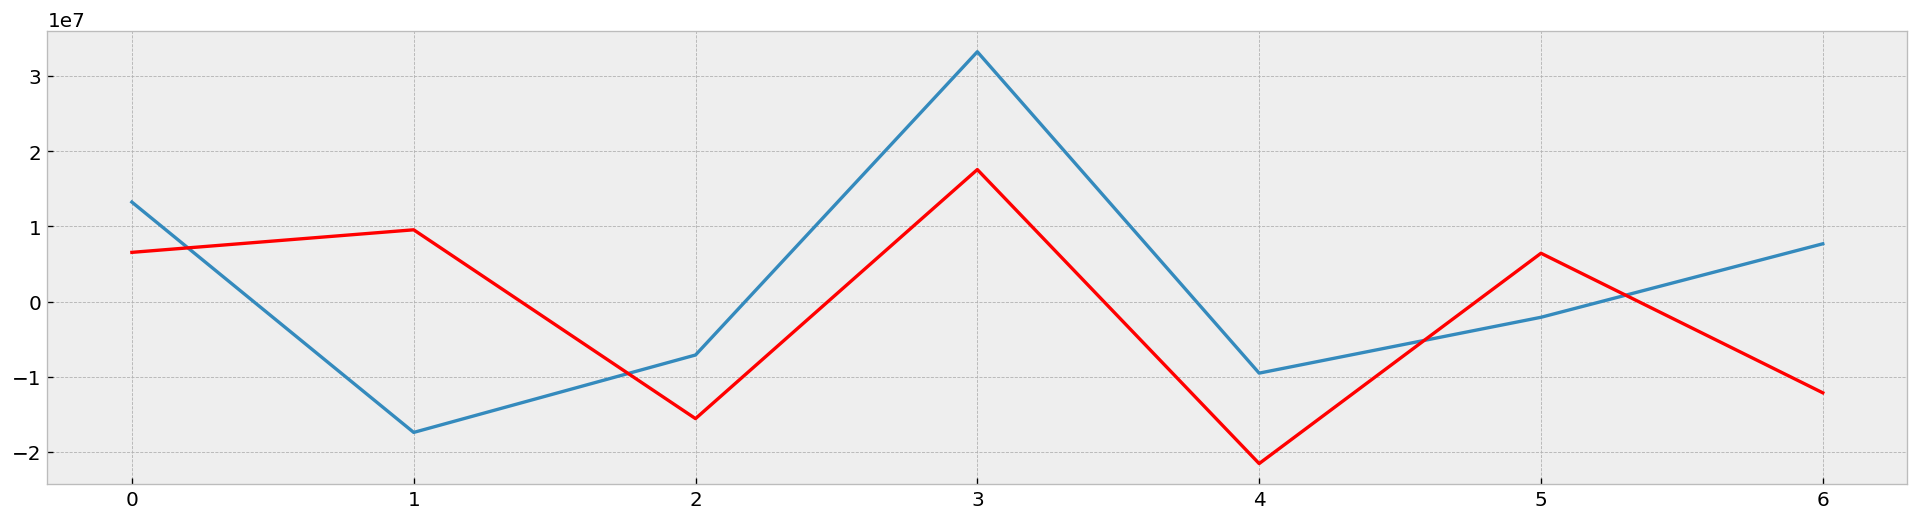

In [41]:
X = energy_per_month['difference'].dropna(inplace=False)
size = int(len(df_training))
train, test = X[0:size], X[size:size+int(len(df_test))]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(2,0,5))
    model_fit = model.fit()
    print(model_fit.summary())
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
    
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual values
plt.plot(pd.Series(test.values))
plt.plot(predictions, color='red')
plt.show()

In [44]:
# Walk throught the test data, training and predicting 1 month ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test))):
    temp_train = arima_data[:len(df_training)+t]
    model = ARIMA(temp_train, order=(2, 0, 5))
    model_fit = model.fit()
    # summary of fit model
    print(model_fit.summary())
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['ARIMA'] = evaluate_all(df_test.values, yhat.values)
predictionsDict['ARIMA'] = yhat

 14%|███████▍                                            | 1/7 [00:00<00:02,  2.16it/s]

                               SARIMAX Results                                
Dep. Variable:             difference   No. Observations:                   71
Model:                 ARIMA(2, 0, 5)   Log Likelihood               -1275.547
Date:                Sun, 24 Oct 2021   AIC                           2569.093
Time:                        23:12:52   BIC                           2589.457
Sample:                    02-28-2013   HQIC                          2577.191
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.127e+05   7.51e+05     -0.815      0.415   -2.09e+06     8.6e+05
ar.L1          0.2470      0.239      1.033      0.302      -0.222       0.716
ar.L2          0.6013      0.288      2.087      0.0

 29%|██████████████▊                                     | 2/7 [00:00<00:02,  2.39it/s]

                               SARIMAX Results                                
Dep. Variable:             difference   No. Observations:                   72
Model:                 ARIMA(2, 0, 5)   Log Likelihood               -1287.965
Date:                Sun, 24 Oct 2021   AIC                           2593.930
Time:                        23:12:52   BIC                           2614.420
Sample:                    02-28-2013   HQIC                          2602.087
                         - 01-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.203e+05   3.69e-08  -1.14e+13      0.000    -4.2e+05    -4.2e+05
ar.L1         -1.9116      0.022    -88.533      0.000      -1.954      -1.869
ar.L2         -0.9964      0.020    -50.826      0.0

 43%|██████████████████████▎                             | 3/7 [00:01<00:01,  2.35it/s]

                               SARIMAX Results                                
Dep. Variable:             difference   No. Observations:                   73
Model:                 ARIMA(2, 0, 5)   Log Likelihood               -1306.935
Date:                Sun, 24 Oct 2021   AIC                           2631.870
Time:                        23:12:52   BIC                           2652.484
Sample:                    02-28-2013   HQIC                          2640.085
                         - 02-28-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.526e+05   3.88e-08  -1.68e+13      0.000   -6.53e+05   -6.53e+05
ar.L1         -1.9138      0.017   -115.902      0.000      -1.946      -1.881
ar.L2         -0.9966      0.016    -63.645      0.0

 57%|█████████████████████████████▋                      | 4/7 [00:01<00:01,  2.13it/s]

                               SARIMAX Results                                
Dep. Variable:             difference   No. Observations:                   74
Model:                 ARIMA(2, 0, 5)   Log Likelihood               -1324.485
Date:                Sun, 24 Oct 2021   AIC                           2666.970
Time:                        23:12:53   BIC                           2687.707
Sample:                    02-28-2013   HQIC                          2675.242
                         - 03-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.397e+05   3.32e-08  -2.23e+13      0.000    -7.4e+05    -7.4e+05
ar.L1         -1.9149      0.014   -134.055      0.000      -1.943      -1.887
ar.L2         -0.9962      0.014    -72.390      0.0

 71%|█████████████████████████████████████▏              | 5/7 [00:02<00:01,  1.94it/s]

                               SARIMAX Results                                
Dep. Variable:             difference   No. Observations:                   75
Model:                 ARIMA(2, 0, 5)   Log Likelihood               -1342.672
Date:                Sun, 24 Oct 2021   AIC                           2703.345
Time:                        23:12:54   BIC                           2724.202
Sample:                    02-28-2013   HQIC                          2711.673
                         - 04-30-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.869e+05   4.66e-08  -6.16e+12      0.000   -2.87e+05   -2.87e+05
ar.L1         -1.9137      0.019   -101.306      0.000      -1.951      -1.877
ar.L2         -0.9974      0.017    -58.856      0.0

 86%|████████████████████████████████████████████▌       | 6/7 [00:02<00:00,  1.96it/s]

                               SARIMAX Results                                
Dep. Variable:             difference   No. Observations:                   76
Model:                 ARIMA(2, 0, 5)   Log Likelihood               -1360.197
Date:                Sun, 24 Oct 2021   AIC                           2738.393
Time:                        23:12:54   BIC                           2759.370
Sample:                    02-28-2013   HQIC                          2746.777
                         - 05-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.081e+05   4.99e-08  -8.18e+12      0.000   -4.08e+05   -4.08e+05
ar.L1         -1.9139      0.017   -114.191      0.000      -1.947      -1.881
ar.L2         -0.9965      0.015    -64.326      0.0

100%|████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.02it/s]

                               SARIMAX Results                                
Dep. Variable:             difference   No. Observations:                   77
Model:                 ARIMA(2, 0, 5)   Log Likelihood               -1377.625
Date:                Sun, 24 Oct 2021   AIC                           2773.249
Time:                        23:12:55   BIC                           2794.344
Sample:                    02-28-2013   HQIC                          2781.687
                         - 06-30-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.298e+05   4.91e-08  -8.75e+12      0.000    -4.3e+05    -4.3e+05
ar.L1         -1.9145      0.016   -122.809      0.000      -1.945      -1.884
ar.L2         -0.9964      0.015    -66.550      0.0

In [45]:
resultsDict['ARIMA']

{'nrmse': nan,
 'mase': 0.5956486145529402,
 'mdape': 1.2652285688047282,
 'smdape': 0.774970904574609,
 'rmsse': 0.6617754208202967,
 'rmse': 15566936.400434153,
 'rae': 1.057024692850417,
 'bias': 3883855.6451223674,
 'mda': 0.5,
 'rmspe': 2.0466445991372333,
 'rrse': 0.9878684766376221,
 'mdae': 12022884.608923983,
 'gmae': 12524352.930286108,
 'mre': 0.4482778482262056,
 'std_ae': 19615858.539473582,
 'inrse': 0.9878684766376221,
 'mbrae': 0.4370541039421935,
 'std_ape': 2.0928663864636294,
 'gmrae': 0.753985493171338,
 'r2': 0.024115872865663746,
 'smape': 1.2591841519131022,
 'mrae': 0.9242455410610204,
 'mae': 14011436.218436161,
 'mape': 1.6651532278859265,
 'me': 3883855.6451223674,
 'mdrae': 0.8507451577183562,
 'maape': 0.8874986261844542,
 'umbrae': 0.7763696422743162,
 'rmdspe': 1.2652285688047282,
 'mad': 14011436.218436161,
 'mse': 242329508895161.84,
 'mpe': 0.96301250956183}

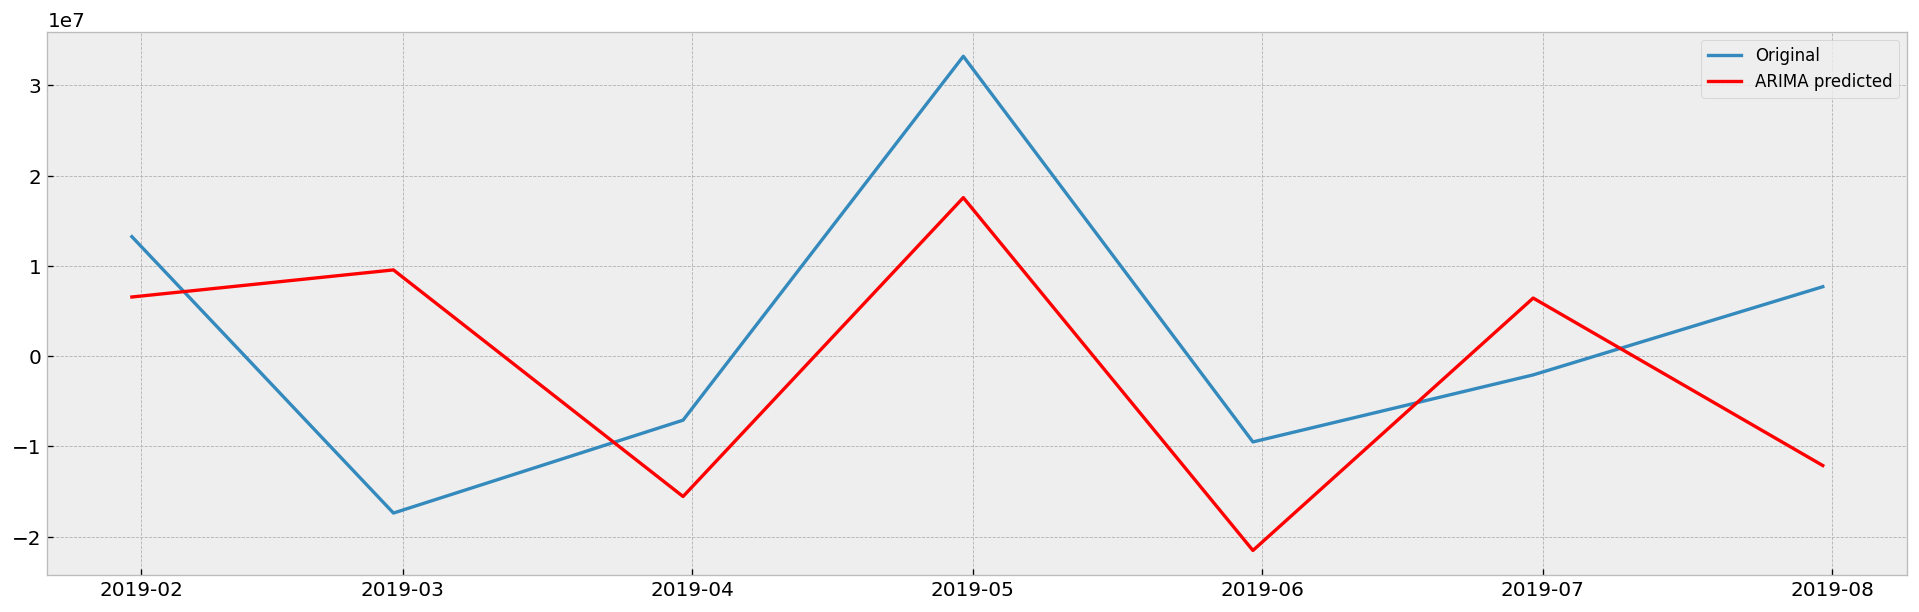

In [46]:
fig = plt.figure(figsize=(20,6))
plt.plot(df_test, label='Original')
plt.plot(yhat, color='red', label='ARIMA predicted')
plt.legend()

In [47]:
start = arima_data[len(df_training):]

 ### <p style="font-family: Arial; font-size:1.2em;color:darkred;"> Modèles ARMA </p>

#### Modèle ARMA pour la série désaisonnalisée et différenciée (p, d, q) = (2, 0, 5)
#### Entraîner le modèle

In [48]:
# Training and predicting 7 months ahead for all the test data at once
yhat = list()
temp_train = df_training
model = ARIMA(temp_train, order=(2, 0, 5))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

start = len(df_training)
end = len(df_test)
 
arima_prediction = model_fit.predict(start = start, end = start + end -1 )
resultsDict['ARIMA 2 0 5'] = evaluate(df_test.values, arima_prediction.values)

                               SARIMAX Results                                
Dep. Variable:             difference   No. Observations:                   71
Model:                 ARIMA(2, 0, 5)   Log Likelihood               -1275.547
Date:                Sun, 24 Oct 2021   AIC                           2569.093
Time:                        23:13:15   BIC                           2589.457
Sample:                    02-28-2013   HQIC                          2577.191
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.127e+05   7.51e+05     -0.815      0.415   -2.09e+06     8.6e+05
ar.L1          0.2470      0.239      1.033      0.302      -0.222       0.716
ar.L2          0.6013      0.288      2.087      0.0

In [49]:
resultsDict['ARIMA 2 0 5']

{'mae': 13355308.889683548,
 'rmse': 18303081.696700726,
 'mape': 1.069126015333234,
 'r2': -0.3490883391045705}

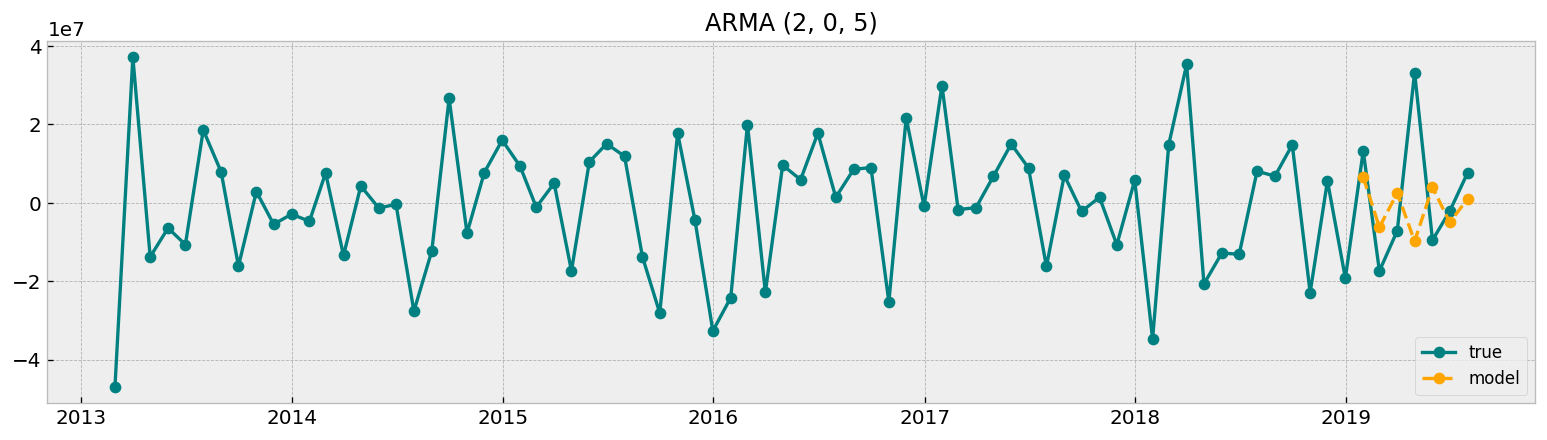

In [50]:
plt.figure(figsize=(16, 4))
plt.plot(energy_per_month['difference'].dropna(inplace=False), '-o', label='true', color='teal')
plt.plot(arima_prediction, '--o', label='model', color='orange')
plt.title('ARMA (2, 0, 5)')
plt.legend();

In [51]:
# Check the model
model = ARIMA(df_training, order=(2, 0, 5))
arima_fit = model.fit()
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             difference   No. Observations:                   71
Model:                 ARIMA(2, 0, 5)   Log Likelihood               -1275.547
Date:                Sun, 24 Oct 2021   AIC                           2569.093
Time:                        23:13:18   BIC                           2589.457
Sample:                    02-28-2013   HQIC                          2577.191
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.127e+05   7.51e+05     -0.815      0.415   -2.09e+06     8.6e+05
ar.L1          0.2470      0.239      1.033      0.302      -0.222       0.716
ar.L2          0.6013      0.288      2.087      0.0

<p style="font-family: Arial; font-size:1.1em;color:darkred;"> NB ! </p> 
Nous observons dans le tableau ci-dessus (modèle summary) que les coefficients de certains lags (e.g., ar.L1, ma.L3) ne sont pas statistiquement importants. Néanmoins, ces lags peuvent être importants pour avoir un mieux modèle. Les statistiques du modèle sont à prendre en compte à titre indicatif.  

In [52]:
arima_data['predicted'] = arima_fit.fittedvalues

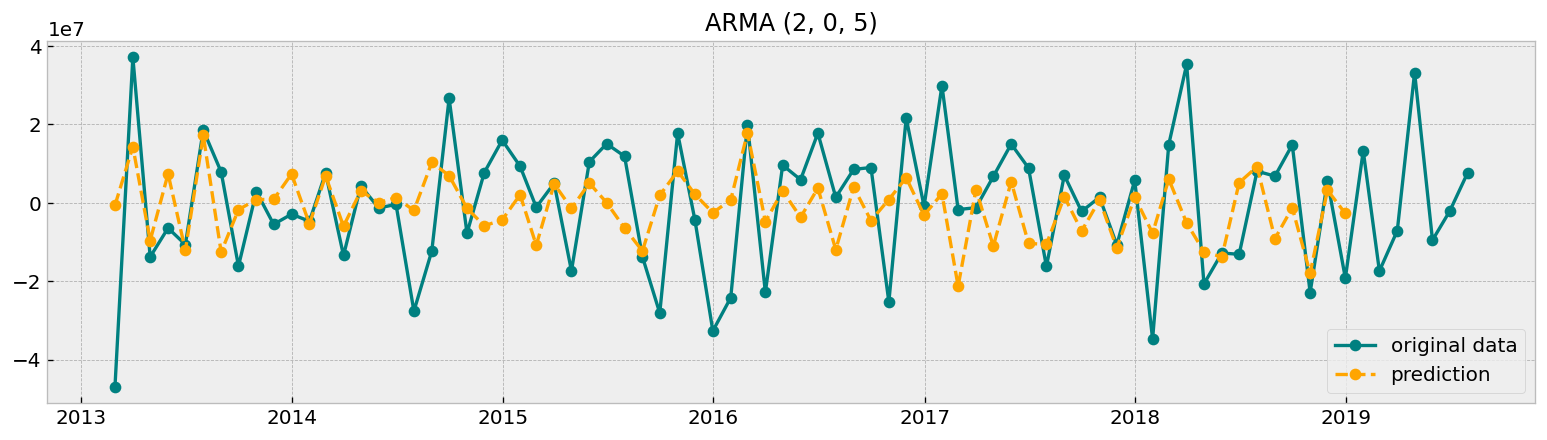

In [53]:
plt.figure(figsize=(16, 4))
plt.plot(energy_per_month['difference'].dropna(inplace=False), '-o', label="original data", color='teal')
plt.plot(arima_data['predicted'], '--o', label='prediction', color='orange')
plt.title('ARMA (2, 0, 5)')
plt.legend(fontsize=12)

In [54]:
# # evaluate error on the train set
print('Train MAE = {0:.3f}'.format(mae(df_training, arima_data['predicted'])))

Train MAE = 11905669.453


In [55]:
# evaluate error on the train set
rmse = sqrt(mean_squared_error(df_training, arima_data['predicted']))
print('Train RMSE: %.3f' % rmse)

Train RMSE: 15529470.173


In [56]:
evaluate(df_training, arima_data['predicted'])

{'mae': 11905669.452775167,
 'rmse': 15529470.172882529,
 'mape': 1.4222615758645683,
 'r2': 0.13369642116034874}

In [57]:
forecast_accuracy(arima_data['predicted'].values, df_training.values)

{'mape': 1.4222615758645683,
 'me': -643821.1445448652,
 'mae': 11905669.452775167,
 'mpe': -0.7072182019511287,
 'rmse': 15529470.172882529,
 'acf1': -0.003926524506393509,
 'corr': 0.37832671428088,
 'minmax': -0.00905504181784833}

#### Vérifier la performance du modèle sur le jeu de test

In [58]:
forecast_stat = arima_fit.get_forecast(7, alpha=0.05)
yhat_arma = forecast_stat.predicted_mean
yhat_arma_conf_int = forecast_stat.conf_int(alpha=0.05)
yhat_arma_conf_int.head()

,lower difference,upper difference
2019-01-31,-2.324817e+07,3.635401e+07
2019-02-28,-3.742582e+07,2.497216e+07
2019-03-31,-2.877682e+07,3.382666e+07
2019-04-30,-4.117789e+07,2.160390e+07
2019-05-31,-2.855850e+07,3.647435e+07


In [59]:
start_index = df_test.index[0]
end_index = df_test.index[-1]
forecast = arima_fit.predict(start_index,end_index)

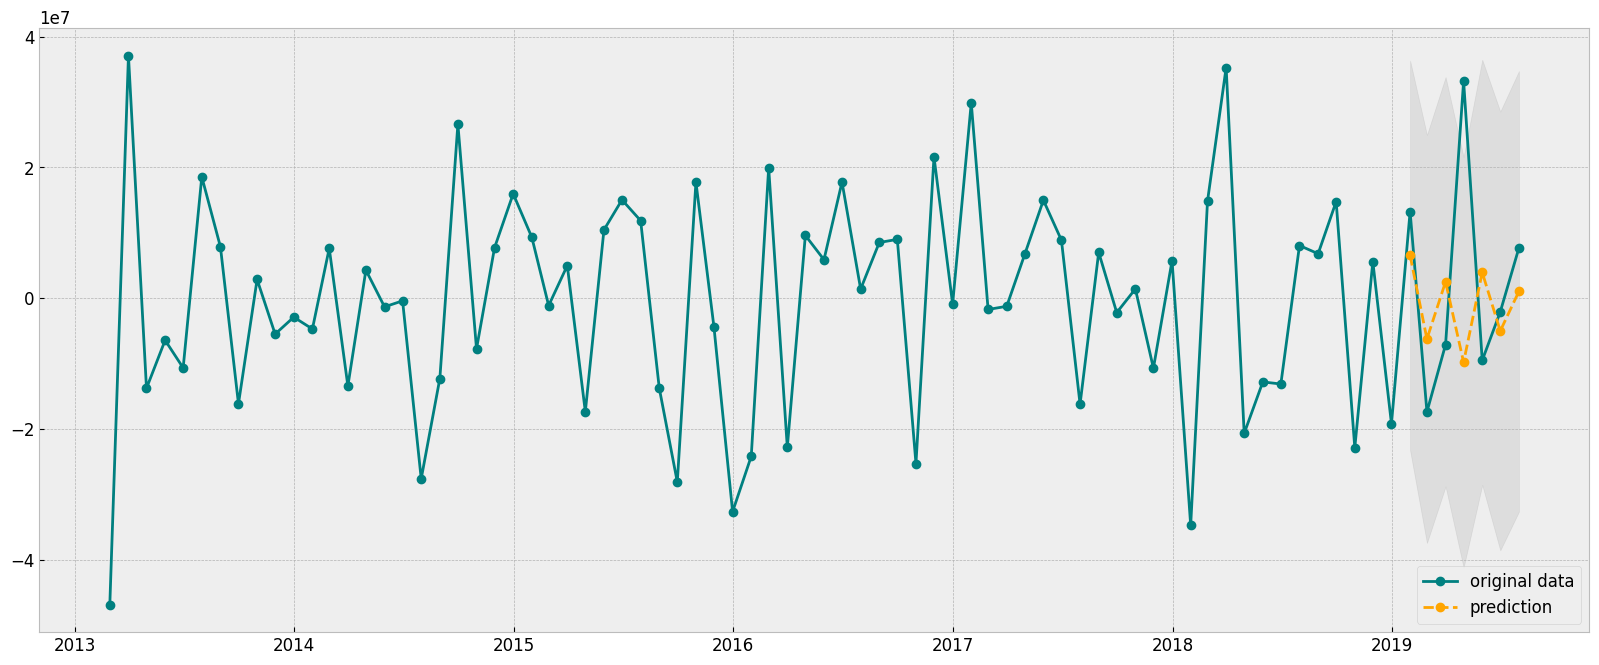

In [60]:
lower_series = pd.Series(yhat_arma_conf_int.loc[:, 'lower difference'], index=df_test.index)
upper_series = pd.Series(yhat_arma_conf_int.loc[:, 'upper difference'], index=df_test.index)
plt.figure(figsize=(20, 8), dpi=100)
plt.plot(energy_per_month['difference'].dropna(inplace=False), '-o', label="original data", color='teal')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='grey', alpha=.15)
plt.plot(forecast, '--o', label='prediction', color='orange')
plt.legend(fontsize=12)

In [61]:
# evaluate error on the test set
rmse = sqrt(mean_squared_error(df_test[start_index:], forecast))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 18303081.697


In [62]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Test MAE = {0:.3f}'.format(mean_absolute_error(df_test[start_index:], forecast)))
print('Test MAE2 = {0:.3f}'.format(mean_absolute_error(df_test[-1:], forecast[-1:]))) #error only for the last 7 months

Test MAE = 13355308.890
Test MAE2 = 6640428.818


In [63]:
evaluate(df_test[start_index:], forecast)

{'mae': 13355308.889683548,
 'rmse': 18303081.696700726,
 'mape': 1.069126015333234,
 'r2': -0.3490883391045705}

In [64]:
evaluate(df_test[-1:], forecast[-1:])

{'mae': 6640428.817648288,
 'rmse': 6640428.817648288,
 'mape': 0.8632588428388047,
 'r2': nan}

In [65]:
forecast_accuracy(forecast.values, df_test.values)

{'mape': 1.069126015333234,
 'me': -3574467.033307582,
 'mae': 13355308.889683548,
 'mpe': -0.6671895958104583,
 'rmse': 18303081.696700726,
 'acf1': -0.45855486194017436,
 'corr': -0.2420653976429336,
 'minmax': 0.9535032504294267}

#### MAPE  de ~ 1.1 % suppose que le modèle est ~ 98.9% précis dans la prédiction des 12 prochaines observations.

### Résiduels

Finalement, nous avons tracé les résiduels afin de voir si il n'y a pas encore des patterns (regarder si la moyenne et la variance sont constantes).  

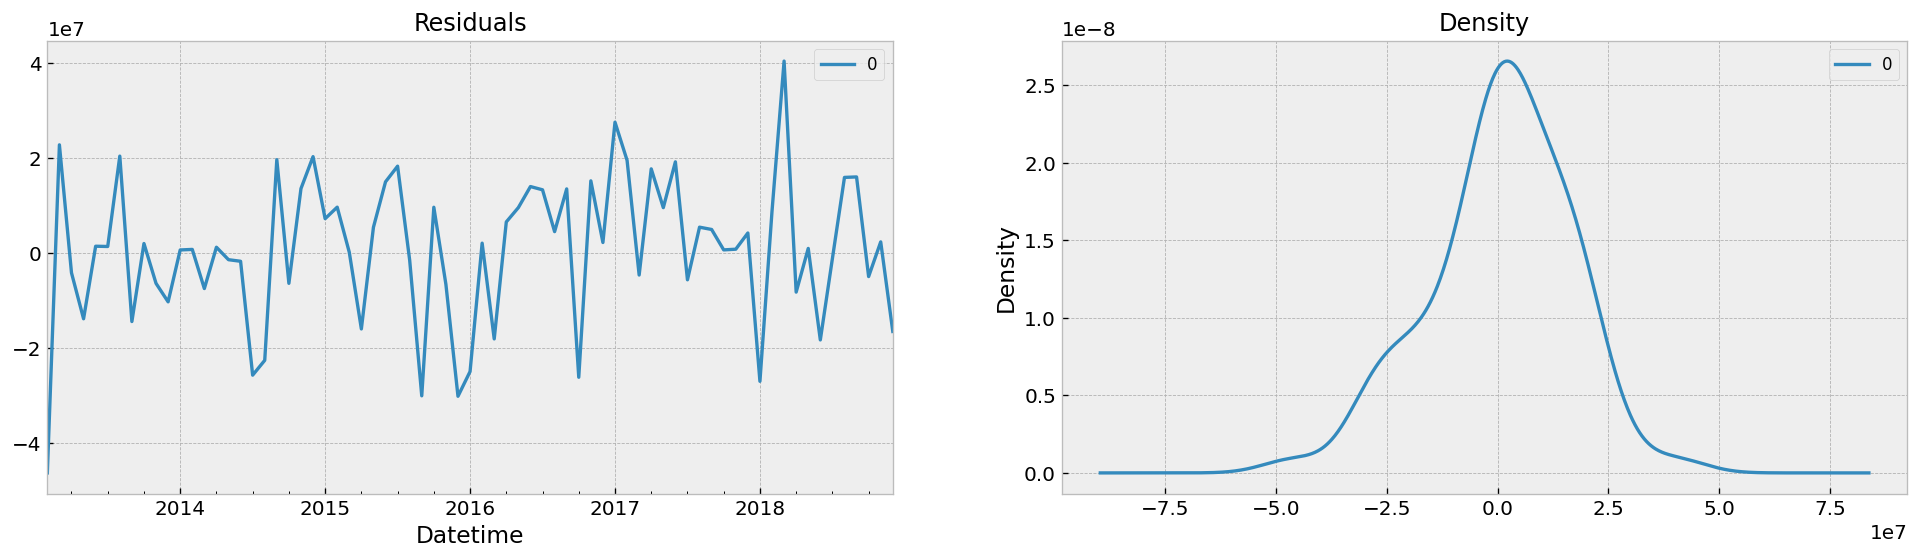

In [66]:
# Plot residual errors for the ARMA (2, 0, 5 model)
residuals = pd.DataFrame(arima_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Les erreurs résiduels semblent avoir une moyenne égale à zero et une variance uniforme.

### Forecasts

In [68]:
model = ARIMA(energy_per_month['difference'], order=(2,0,5))
arima_fit = model.fit()
arima_forecast= arima_fit.forecast(steps=12)

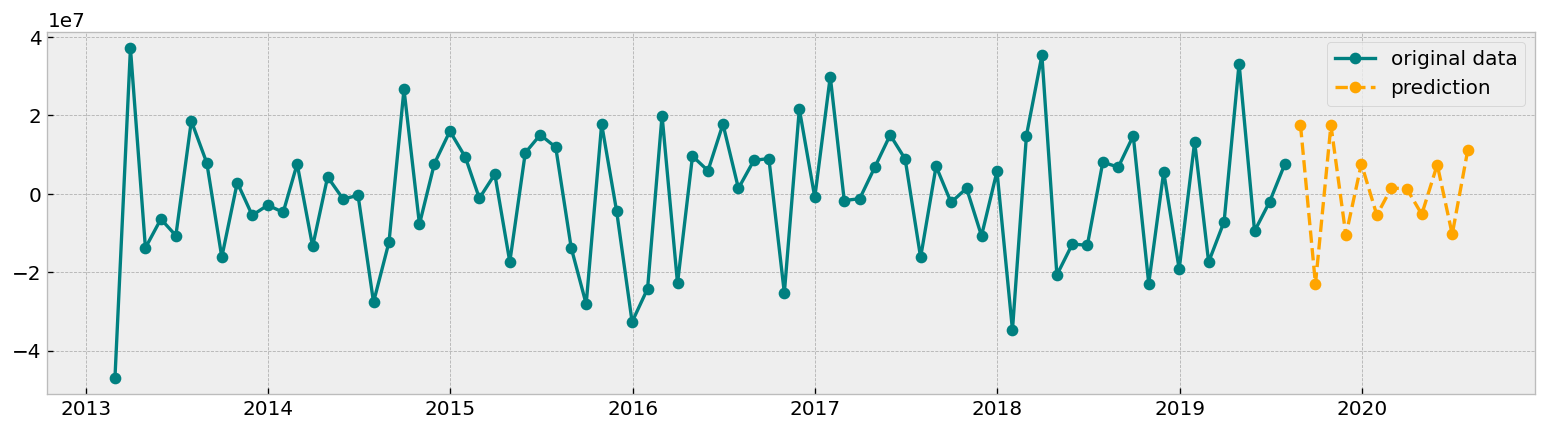

In [69]:
#ARMA model's 12 out of sample predictions
plt.figure(figsize=(16, 4))
plt.plot(energy_per_month['difference'], '-o', label="original data", color='teal')
plt.plot(arima_forecast, '--o', label='prediction', color='orange')
plt.legend(fontsize=12)

In [70]:
# print(energy_per_month.total[-12:]) #the actual last 12 mois

idx = arima_forecast.index.values

forecast_energy_per_month = []
lag = 12
for i, diff in enumerate(arima_forecast): 
    prev_value = energy_per_month.total[-(lag)+i:][0]
    forecast_energy_per_month.append(prev_value+diff)
    
energy_forecast = pd.Series(forecast_energy_per_month, index=idx)

<function matplotlib.pyplot.show(close=None, block=None)>

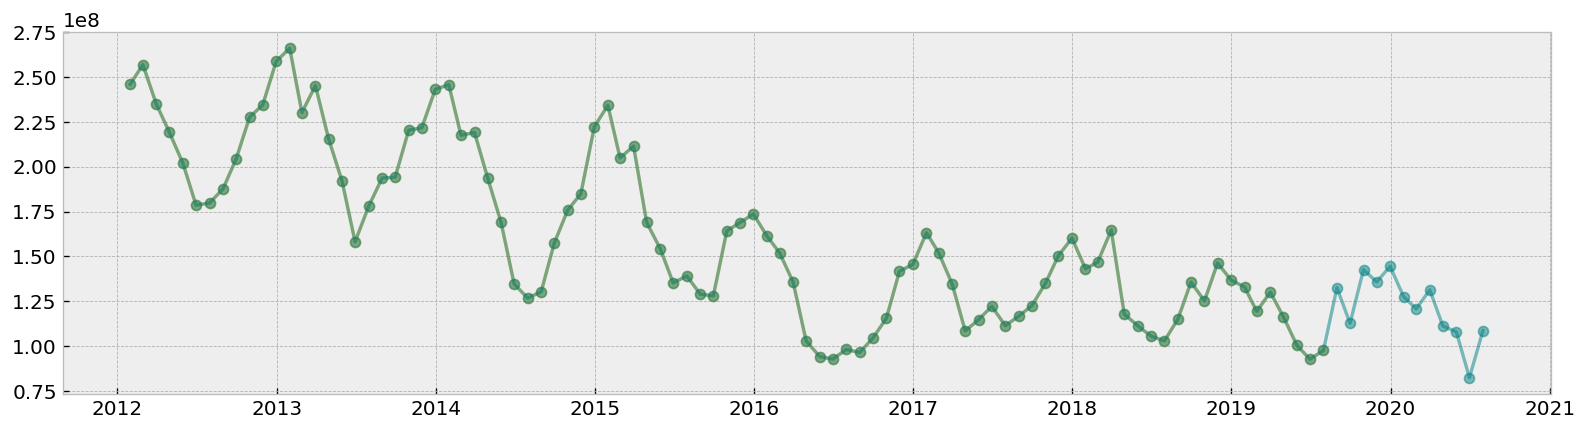

In [71]:
hist_values = energy_per_month['total'].append(energy_forecast)

plt.figure(figsize=(16,4))
plt.plot(energy_per_month['total'], '-o', color='orange', alpha=0.5)
plt.plot(hist_values, '-o', color='teal', alpha=0.5)
plt.show

In [72]:
total = energy_per_month[(energy_per_month['total'].index >= '2013-02-28')]
total = total[(total['total'].index <= '2018-12-31')]
total = total['total']

In [73]:
# print(total[:]) #the actual last 0 mois

idx = arima_data['predicted'].dropna(inplace=False).index.values

predicted_energy_per_month = []
lag = 0
for i, diff in enumerate(arima_data['predicted'].dropna(inplace=False)): 
    prev_value = total[-(lag)+i:][0]
    predicted_energy_per_month.append(prev_value+diff)
    
energy_predicted = pd.Series(predicted_energy_per_month, index=idx)

<function matplotlib.pyplot.show(close=None, block=None)>

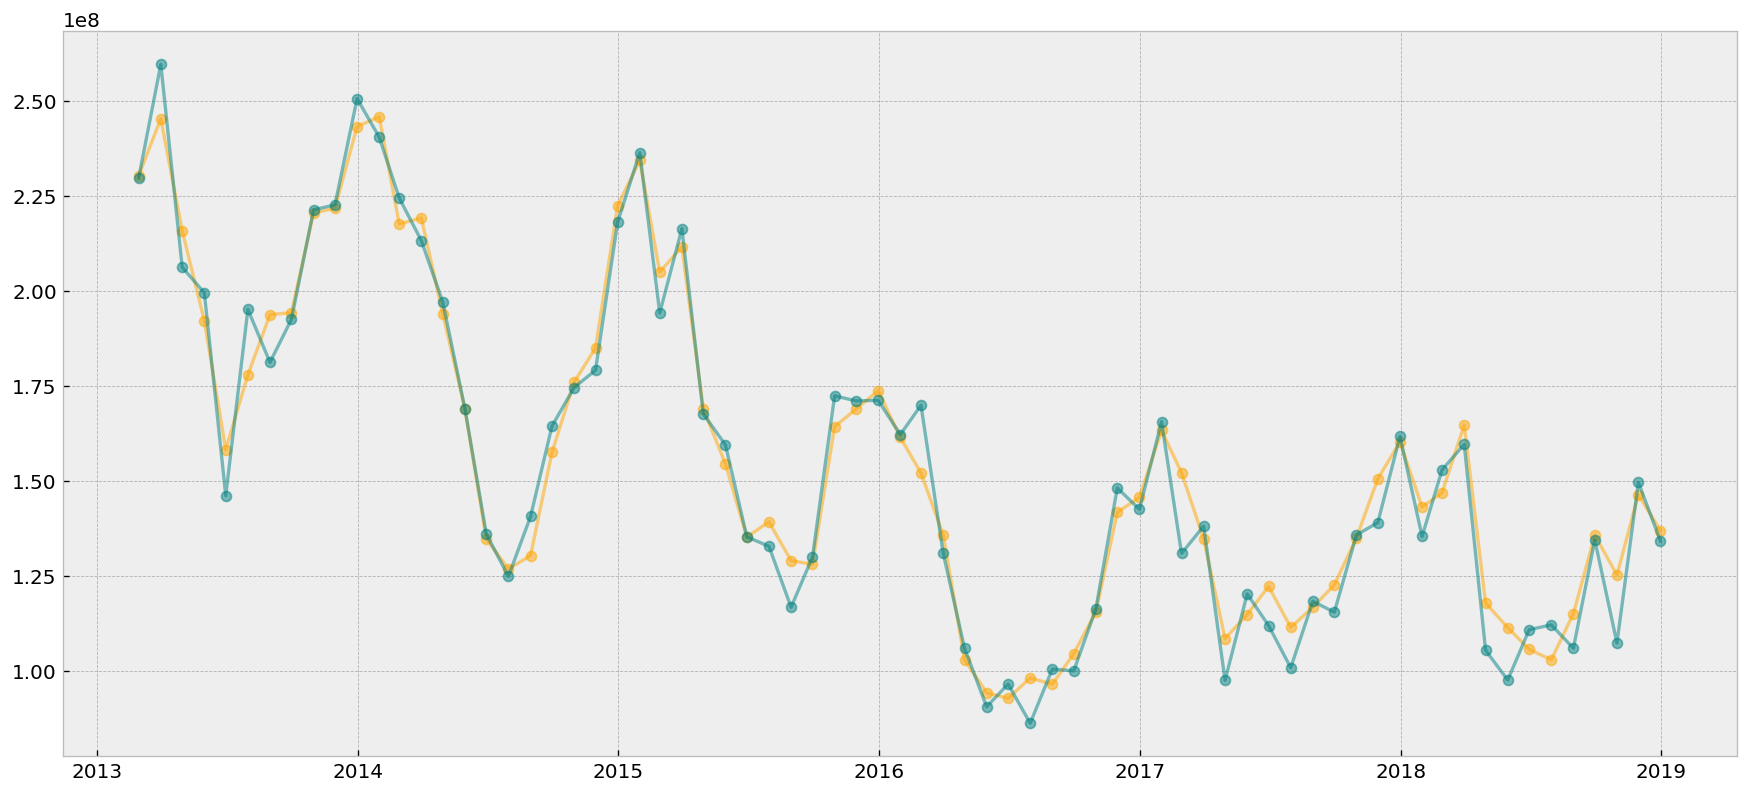

In [74]:
hist_values = energy_predicted  

plt.figure(figsize=(18,8))
plt.plot(total, '-o', color='orange', alpha=0.5)
plt.plot(hist_values, '-o', color='teal', alpha=0.5)
plt.show

In [75]:
print('MAE = {0:.3f}'.format(mean_absolute_error(total, energy_predicted)))

MAE = 6209636.128


In [76]:
evaluate(total, energy_predicted)

{'mae': 6209636.127545719,
 'rmse': 7900135.996500946,
 'mape': 0.04335703701844352,
 'r2': 0.9641257834666761}

In [77]:
fc = arima_fit.forecast(12, alpha=0.05)  # 95% conf
conf_ins = arima_fit.get_forecast(12).summary_frame()
conf_ins

difference,mean,mean_se,mean_ci_lower,mean_ci_upper
2019-08-31,1.755035e+07,1.541852e+07,-1.266940e+07,4.777009e+07
2019-09-30,-2.297463e+07,1.541551e+07,-5.318848e+07,7.239214e+06
2019-10-31,1.750371e+07,1.693790e+07,-1.569398e+07,5.070139e+07
2019-11-30,-1.056877e+07,1.769593e+07,-4.525216e+07,2.411463e+07
2019-12-31,7.660143e+06,1.769605e+07,-2.702348e+07,4.234377e+07
2020-01-31,-5.419484e+06,1.769647e+07,-4.010392e+07,2.926496e+07
2020-02-29,1.477823e+06,1.769960e+07,-3.321276e+07,3.616840e+07
2020-03-31,1.291655e+06,1.770698e+07,-3.341338e+07,3.599669e+07
2020-04-30,-5.217510e+06,1.771875e+07,-3.994562e+07,2.951060e+07
2020-05-31,7.430337e+06,1.773367e+07,-2.732702e+07,4.218769e+07


In [78]:
forecast_stat = arima_fit.get_forecast(12, alpha=0.05)
yhat_arma = forecast_stat.predicted_mean
yhat_arma_conf_int = forecast_stat.conf_int(alpha=0.05)
yhat_arma_conf_int.head()

,lower difference,upper difference
2019-08-31,-1.266940e+07,4.777009e+07
2019-09-30,-5.318848e+07,7.239214e+06
2019-10-31,-1.569398e+07,5.070139e+07
2019-11-30,-4.525216e+07,2.411463e+07
2019-12-31,-2.702348e+07,4.234377e+07


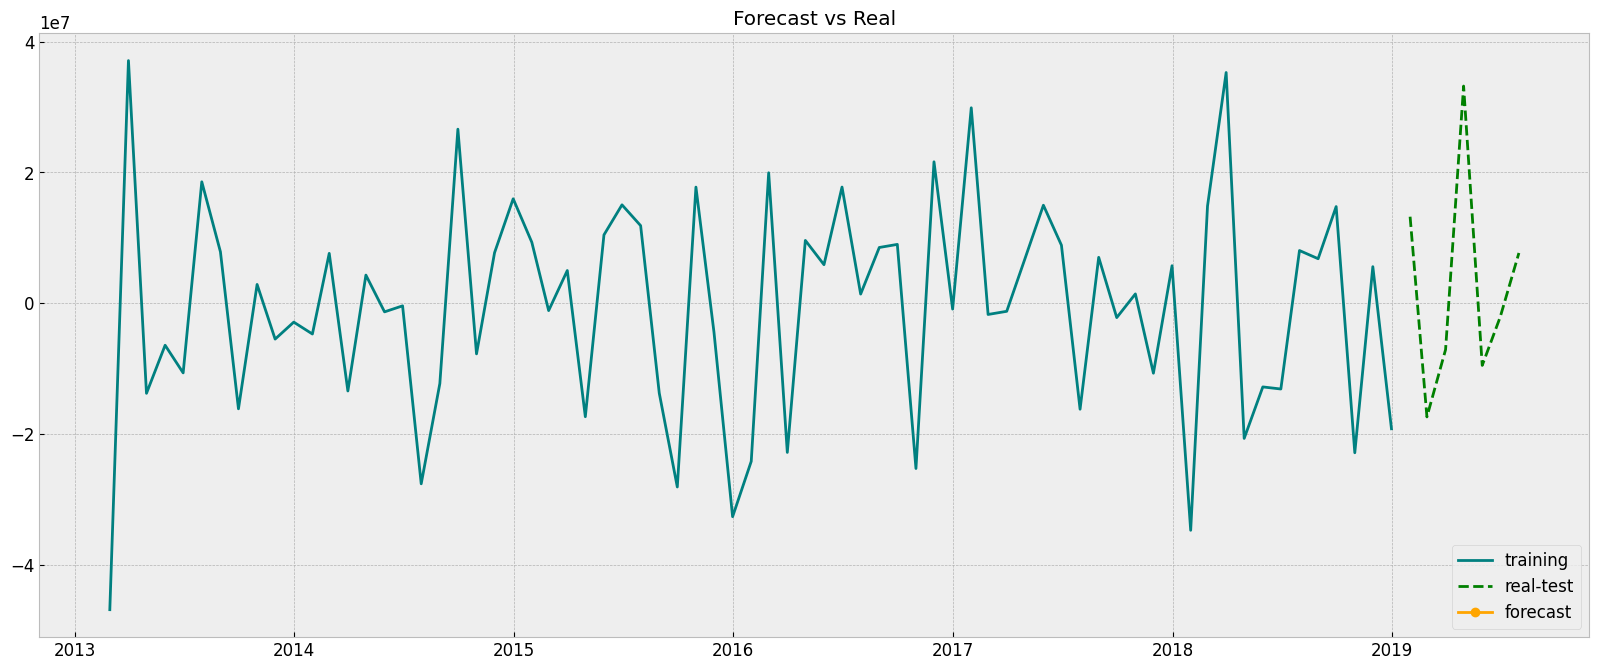

In [79]:
# Pandas series
fc_series = pd.Series(fc, index=df_test.index)
lower_series = pd.Series(conf_ins.loc[:, 'mean_ci_lower'], index=df_test.index)
upper_series = pd.Series(conf_ins.loc[:, 'mean_ci_upper'], index=df_test.index)

# Plot
plt.figure(figsize=(20,8), dpi=100)
plt.plot(df_training, '-', label='training', color='teal')
plt.plot(df_test, '--', label='real-test', color ='green')
plt.plot(fc_series, '-o', label='forecast', color ='orange')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='grey', alpha=.15)
plt.title('Forecast vs Real')
plt.legend(loc='lower right', fontsize=12)
plt.show()

 ### <p style="font-family: Arial; font-size:1.2em;color:darkred;"> Modèles ARIMA </p>
 
 
 Modèle avec d = 1

In [80]:
# We split our dataset into train and test
arima_data_i = energy_per_month['de-season'].dropna(inplace=False)
resultsDict_i = {}
predictionsDict_i = {}

split_date = '2018-12-31'
df_training_i = arima_data_i.loc[arima_data_i.index <= split_date]
df_test_i = arima_data_i.loc[arima_data_i.index > split_date]
print(f"{len(df_training_i)} months of training data \n {len(df_test_i)} months of testing data ")

72 months of training data 
 7 months of testing data 


 ### <p style="font-family: Arial; font-size:1.0em;color:darkred;"> Grid search ARIMA </p>
 
 Nous allons utiliser la série désaisonnalisée mais non-stationnaire et laisser à ARIMA de la stationnariser. Le modèle ARIMA (2, 1, 5) est retenu d'après les résultats du grid search (voir ci-dessous).

In [81]:
X_i = energy_per_month['de-season'].dropna(inplace=False)

In [82]:
p_values = range(2, 10)
d_values_i = range(1, 2) # ARIMA with d = 1
q_values = range(2, 9)

In [83]:
arima_grid_i = evaluate_models(X_i, p_values, d_values_i, q_values)

ARIMA(2, 1, 2) RMSE=19206843.804
ARIMA(2, 1, 3) RMSE=17625311.477
ARIMA(2, 1, 4) RMSE=17940172.584
ARIMA(2, 1, 5) RMSE=15814697.247
ARIMA(2, 1, 6) RMSE=18338998.691
ARIMA(2, 1, 7) RMSE=16385645.416
ARIMA(2, 1, 8) RMSE=18723555.969
ARIMA(3, 1, 2) RMSE=15876453.170
ARIMA(3, 1, 3) RMSE=17641727.631
ARIMA(3, 1, 4) RMSE=14732915.629
ARIMA(3, 1, 5) RMSE=20422259.843
ARIMA(3, 1, 6) RMSE=16120052.339
ARIMA(3, 1, 7) RMSE=16049642.814
ARIMA(3, 1, 8) RMSE=18594109.753
ARIMA(4, 1, 2) RMSE=16929871.106
ARIMA(4, 1, 3) RMSE=15984059.334
ARIMA(4, 1, 4) RMSE=20306676.620
ARIMA(4, 1, 5) RMSE=19898535.908
ARIMA(4, 1, 6) RMSE=14710657.297
ARIMA(4, 1, 7) RMSE=14070117.498
ARIMA(4, 1, 8) RMSE=13896656.548
ARIMA(5, 1, 2) RMSE=16850184.430
ARIMA(5, 1, 3) RMSE=14537712.391
ARIMA(5, 1, 4) RMSE=17720195.416
ARIMA(5, 1, 5) RMSE=20781874.904
ARIMA(5, 1, 6) RMSE=17604349.822
ARIMA(5, 1, 7) RMSE=18274084.986
ARIMA(5, 1, 8) RMSE=16178285.064
ARIMA(6, 1, 2) RMSE=15268657.127
ARIMA(6, 1, 3) RMSE=15652650.105
ARIMA(6, 1

In [84]:
arima_grid_i.sort_values('AIC').head(5)

,pdq,rmse,AIC,BIC
0,"(6, 1, 4)",1.431011e+07,2736.438734,2762.076801
0,"(2, 1, 5)",1.581470e+07,2737.257583,2755.903449
0,"(8, 1, 6)",1.525044e+07,2737.702848,2772.663848
0,"(5, 1, 6)",1.760435e+07,2737.897418,2765.866218
0,"(6, 1, 5)",2.092410e+07,2738.470119,2766.438920


In [85]:
arima_grid_i.sort_values('BIC').head(5)

,pdq,rmse,AIC,BIC
0,"(2, 1, 5)",1.581470e+07,2737.257583,2755.903449
0,"(3, 1, 2)",1.587645e+07,2742.563594,2756.547994
0,"(2, 1, 2)",1.920684e+07,2745.008531,2756.662198
0,"(2, 1, 3)",1.762531e+07,2743.729749,2757.714149
0,"(6, 1, 2)",1.526866e+07,2739.638086,2760.614686


In [86]:
arima_grid_i.sort_values('rmse').head(5)

,pdq,rmse,AIC,BIC
0,"(4, 1, 8)",1.389666e+07,2747.612160,2777.911694
0,"(6, 1, 6)",1.391117e+07,2752.566843,2782.866376
0,"(4, 1, 7)",1.407012e+07,2742.365776,2770.334576
0,"(6, 1, 4)",1.431011e+07,2736.438734,2762.076801
0,"(5, 1, 3)",1.453771e+07,2746.749431,2767.726031


In [87]:
# Training and predicting 7 months ahead for all the test data at once
temp_train_i = df_training_i
model_i = ARIMA(temp_train_i, order=(2, 1, 5))
model_fit_i = model_i.fit()
# summary of fit model
print(model_fit_i.summary())

start_i = len(df_training_i)
end_i = len(df_test_i)
 
arima_prediction_i = model_fit_i.predict(start = start_i, end = start_i + end_i -1 )
resultsDict_i['ARIMA 2 1 5'] = evaluate(df_test_i.values, arima_prediction_i.values)

                               SARIMAX Results                                
Dep. Variable:              de-season   No. Observations:                   72
Model:                 ARIMA(2, 1, 5)   Log Likelihood               -1274.238
Date:                Sun, 24 Oct 2021   AIC                           2564.476
Time:                        23:18:19   BIC                           2582.578
Sample:                    01-31-2013   HQIC                          2571.675
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1796      0.229      0.783      0.434      -0.270       0.629
ar.L2          0.5617      0.287      1.955      0.051      -0.002       1.125
ma.L1         -0.5489      0.357     -1.537      0.1

### Prédictions sur le jeu de données train

In [88]:
arima_data_i['predicted'] = model_fit_i.fittedvalues

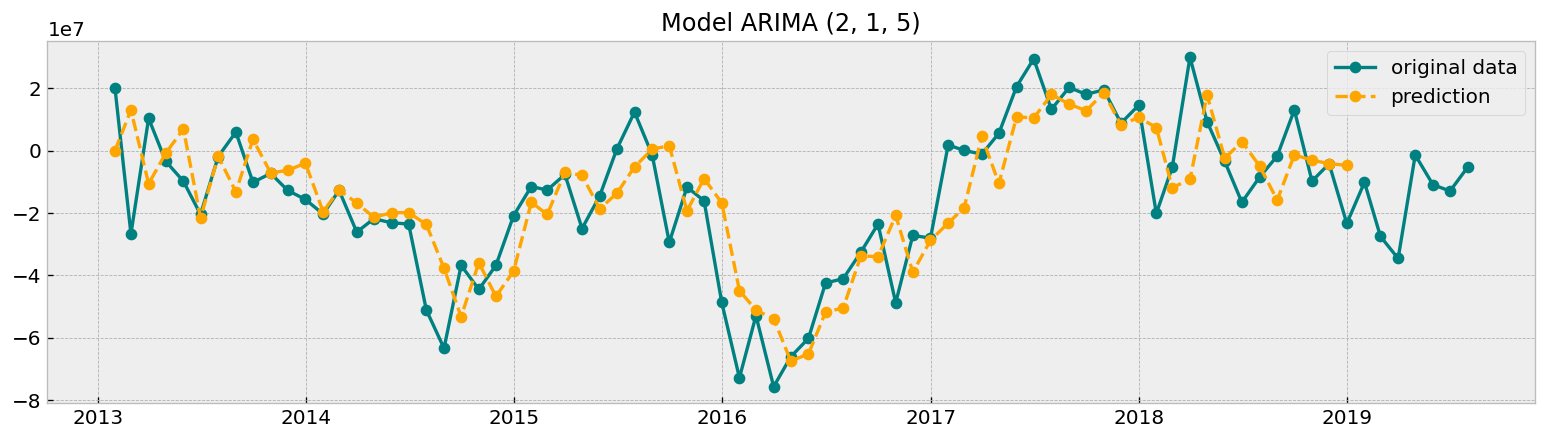

In [89]:
plt.figure(figsize=(16, 4))
plt.plot(energy_per_month['de-season'].dropna(inplace=False), '-o', label="original data", color='teal')
plt.plot(arima_data_i['predicted'], '--o', label='prediction', color='orange')
plt.title('Model ARIMA (2, 1, 5)')
plt.legend(fontsize=12)

In [90]:
# # evaluate error on the train set
print('Train MAE = {0:.3f}'.format(mae(df_training_i, arima_data_i['predicted'])))
print('Train MAPE = {0:.3f}'.format(mape(df_training_i, arima_data_i['predicted'])))
print('Train MSE = {0:.3f}'.format(mse(df_training_i, arima_data_i['predicted'])))

Train MAE = 11481686.226
Train MAPE = 3.663
Train MSE = 231779418589020.062


In [91]:
evaluate(df_training_i, arima_data_i['predicted'])

{'mae': 11481686.226190928,
 'rmse': 15224303.550212733,
 'mape': 3.662606037984049,
 'r2': 0.6040853175905487}

### Prédictions sur le jeu de données test

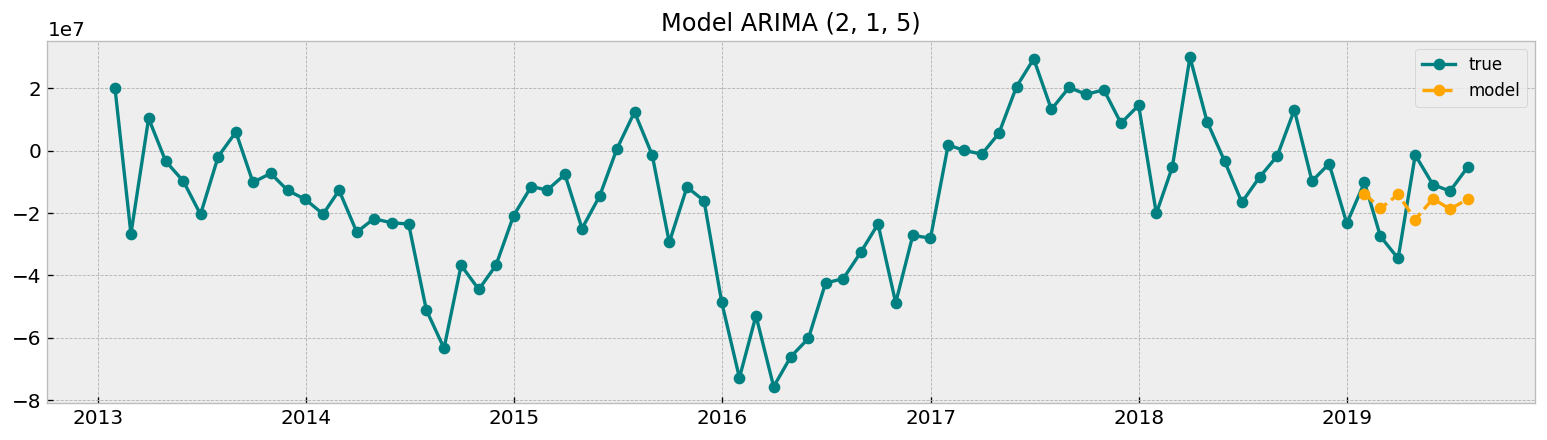

In [92]:
plt.figure(figsize=(16, 4))
plt.plot(energy_per_month['de-season'].dropna(inplace=False), '-o', label='true', color='teal')
plt.plot(arima_prediction_i, '--o', label='model', color='orange')
plt.title('Model ARIMA (2, 1, 5)')
plt.legend();

In [93]:
evaluate(df_test_i, arima_prediction_i)

{'mae': 10645052.047367942,
 'rmse': 12569313.38504981,
 'mape': 2.72679271985962,
 'r2': -0.27859915044268635}

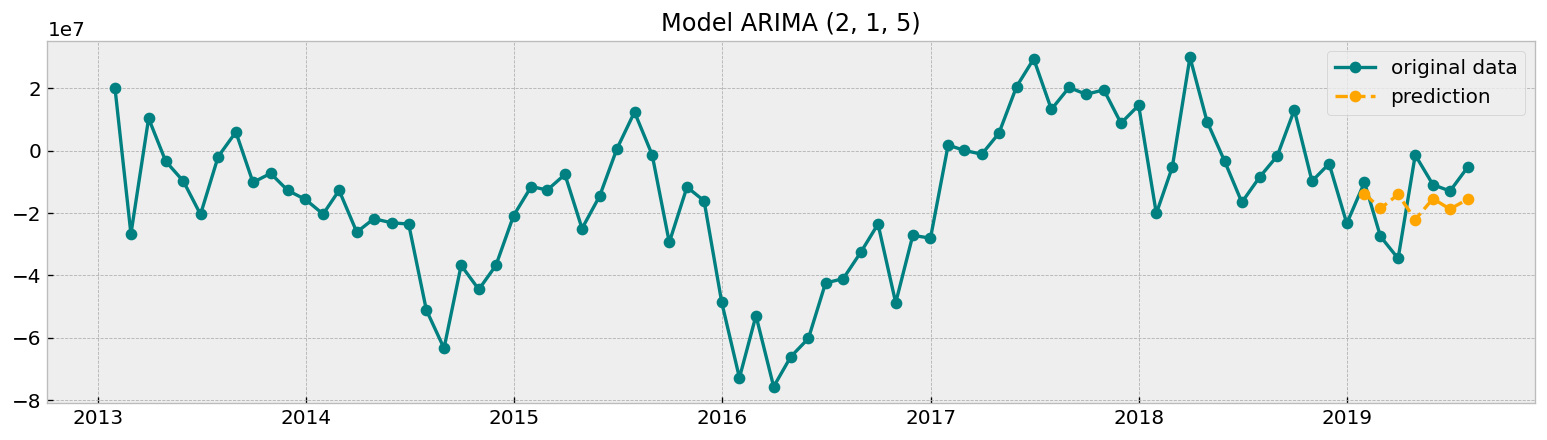

In [94]:
start_index_i = df_test_i.index[0]
end_index_i = df_test_i.index[-1]
forecast_i = model_fit_i.predict(start_index_i,end_index_i)

plt.figure(figsize=(16, 4))
plt.plot(energy_per_month['de-season'].dropna(inplace=False), '-o', label="original data", color='teal')
plt.plot(forecast_i, '--o', label='prediction', color='orange')
plt.title('Model ARIMA (2, 1, 5)')
plt.legend(fontsize=12)

In [95]:
evaluate(df_test_i[start_index:], forecast_i)

{'mae': 10645052.047367942,
 'rmse': 12569313.38504981,
 'mape': 2.72679271985962,
 'r2': -0.27859915044268635}

In [96]:
evaluate(df_test_i[-1:], forecast_i[-1:])

{'mae': 10304858.017386353,
 'rmse': 10304858.017386353,
 'mape': 1.95515128260671,
 'r2': nan}

In [97]:
forecast_stat_i = model_fit_i.get_forecast(7, alpha=0.05)
yhat_arima = forecast_stat_i.predicted_mean
yhat_arima_conf_int = forecast_stat_i.conf_int(alpha=0.05)
yhat_arima_conf_int.head(10)

,lower de-season,upper de-season
2019-01-31,-4.353575e+07,1.595809e+07
2019-02-28,-5.387181e+07,1.677663e+07
2019-03-31,-5.302878e+07,2.493221e+07
2019-04-30,-6.328644e+07,1.906560e+07
2019-05-31,-6.169750e+07,3.087019e+07
2019-06-30,-6.649539e+07,2.901531e+07
2019-07-31,-6.548556e+07,3.433460e+07


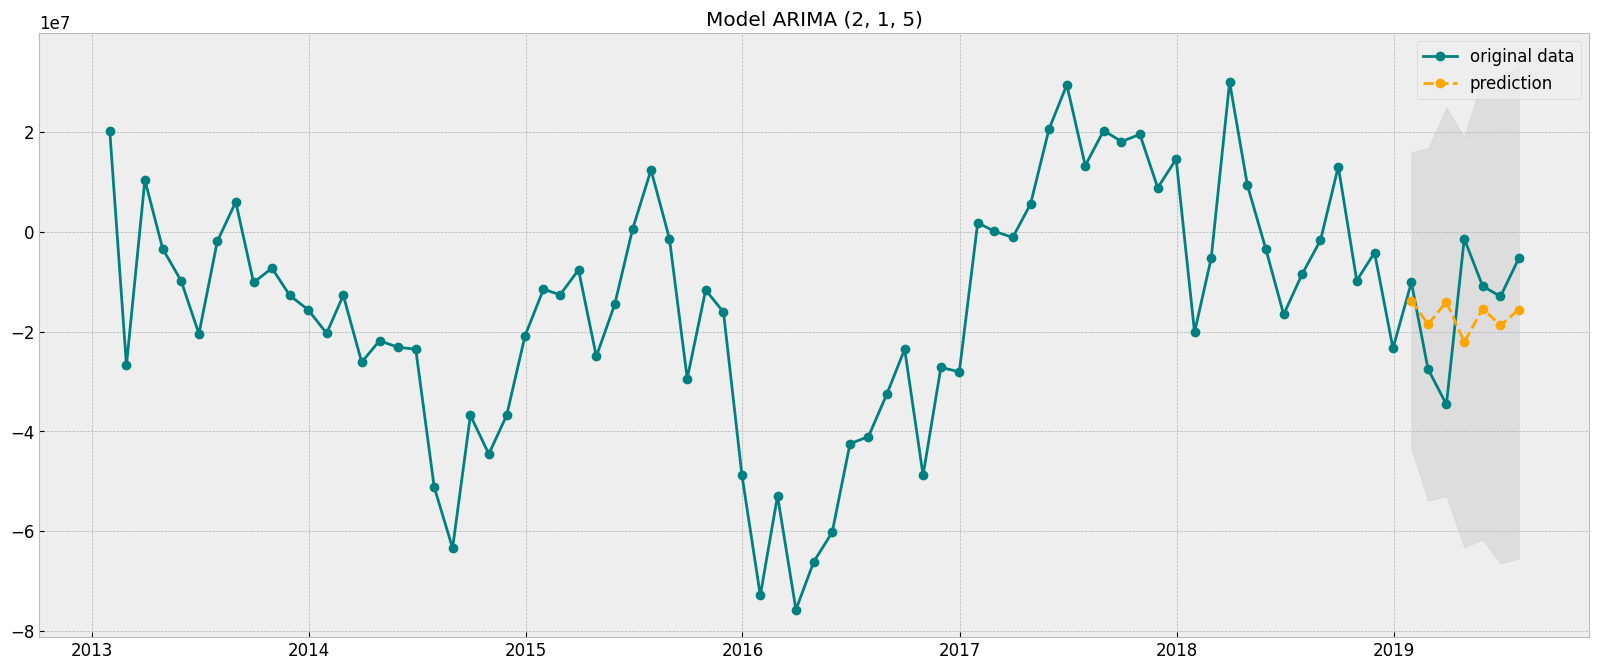

In [98]:
lower_series_i = pd.Series(yhat_arima_conf_int.loc[:, 'lower de-season'], index=df_test_i.index)
upper_series_i = pd.Series(yhat_arima_conf_int.loc[:, 'upper de-season'], index=df_test_i.index)
plt.figure(figsize=(20, 8), dpi=100)
plt.plot(energy_per_month['de-season'].dropna(inplace=False), '-o', label="original data", color='teal')
plt.fill_between(lower_series_i.index, lower_series_i, upper_series_i, 
                 color='grey', alpha=.15)
plt.plot(forecast_i, '--o', label='prediction', color='orange')
plt.title('Model ARIMA (2, 1, 5)')
plt.legend(fontsize=12)

In [99]:
evaluate(df_test_i[start_index:], forecast_i)

{'mae': 10645052.047367942,
 'rmse': 12569313.38504981,
 'mape': 2.72679271985962,
 'r2': -0.27859915044268635}

### Forecast

In [100]:
model = ARIMA(energy_per_month['de-season'], order=(2,1,5))
arima_fit_i = model.fit()
arima_forecast_i= arima_fit_i.forecast(steps=12)

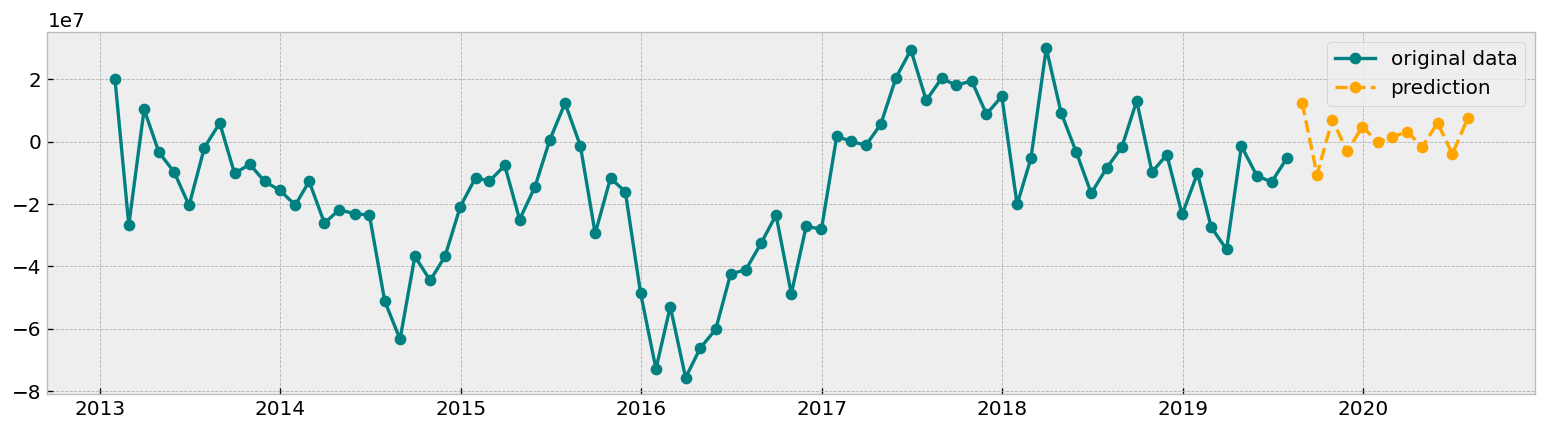

In [101]:
#ARIMA model's 12 out of sample predictions
plt.figure(figsize=(16, 4))
plt.plot(energy_per_month['de-season'], '-o', label="original data", color='teal')
plt.plot(arima_forecast_i, '--o', label='prediction', color='orange')
plt.legend(fontsize=12)

In [102]:
# print(energy_per_month.total[-12:]) #the actual last 12 mois

idx = arima_forecast_i.index.values

forecast_energy_per_month_i = []
lag = 12
for i, diff in enumerate(arima_forecast_i): 
    prev_value_i = energy_per_month.total[-(lag)+i:][0]
    forecast_energy_per_month_i.append(prev_value_i+diff)
    
energy_forecast_i = pd.Series(forecast_energy_per_month_i, index=idx)

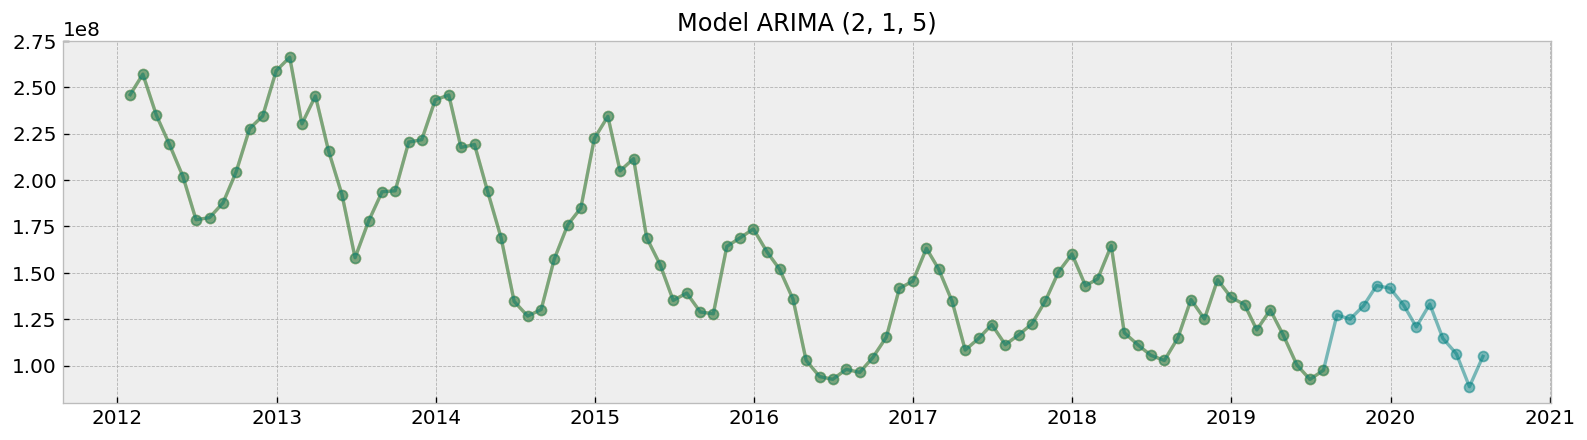

In [103]:
hist_values = energy_per_month['total'].append(energy_forecast_i)

plt.figure(figsize=(16,4))
plt.plot(energy_per_month['total'], '-o', color='orange', alpha=0.5)
plt.plot(hist_values, '-o', color='teal', alpha=0.5)
plt.title('Model ARIMA (2, 1, 5)')
plt.show()